In [1]:
#!pip

## r1_correctLC

In [1]:
from astropy import stats #for MAD

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from lightkurve import LightCurve
import astropy.units as u
import logging
#import batman-package as batman
#batman = __import__("batman-package")
import matplotlib
#from basic_functions import stop

logging.basicConfig(format='%(asctime)s %(levelname)s: %(name)s(%(funcName)s): %(message)s', level=logging.DEBUG)

import tessutils #NOT the normal utils!

#dataDir = "data"
#downloadDir = "mastDownload/TESS"
#outdir = "results_notCorrectedForSineLong"
#correctSine = False

###################################################################################################


2019-12-16 10:46:34,349 DEBUG: matplotlib.pyplot(switch_backend): Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [5]:
import matplotlib.pyplot as plt
from astropy.table import Table
import astropy.units as u
from astropy.io import fits 
import os
from lightkurve import LightCurve
from lightkurve import BoxLeastSquaresPeriodogram as BLS
#import lightkurve as lk
import numpy as np
import requests
import gzip 
import pickle

import logging
logger = logging.getLogger(__name__)

import subprocess
from matplotlib import rc

import os
import shutil

In [6]:
lc = None
folderName = 'tess2018206045859-s0001-0000000092352620-0120-s'
downloadDir = 'CleanPath/LowMags/TIC_92352620/' #Path must flow like this

lc, sectors = tessutils.loadLC(folderName, downloadDir, fluxType="PDCSAP", normalised=True)
lcOri = lc.copy()

# Show what it looks like
#plt.figure()
#plt.scatter(lc.time, lc.flux, label="LC", marker='.', s=5)
#lcB = lc.bin(100, method="median")
#plt.scatter(lcB.time, lcB.flux, label="LC", marker='.', s=5)
#plt.savefig(os.path.join(downloadDir, "TIC_92352620_raw.pdf"))
#plt.show()

2019-12-16 10:47:34,047 INFO: tessutils(loadLC): Cadence is 2 min for CleanPath/LowMags/TIC_92352620/tess2018206045859-s0001-0000000092352620-0120-s\tess2018206045859-s0001-0000000092352620-0120-s_lc.fits


## Median Detrend

In [6]:
def medianDetrend(lc, windowFactorDurationTransit, returnMedians=False): #remove durationTransitHour
    
    #durationTransit = durationTransitHour / 24.
    window = windowFactorDurationTransit # * durationTransit
    
    t = lc.time / window
    t -= np.amin(t)
    tMax = int(np.ceil(np.amax(t)))
    
    medians = []
    ts = []
    te = []
    for windowStart in range(0, tMax):
        ts.append(windowStart)
        te.append(windowStart+1.)
        currentIds = np.where(np.logical_and(t >= windowStart, t < windowStart+1.))
        median = np.nanmedian(lc.flux[currentIds])
        medians.append(median)
        lc.flux_err[currentIds] /= median        
        lc.flux[currentIds] /= median

    if returnMedians:
        return lc, medians, ts, te, t
    return lc 

## (Removed) Light Curve

In [7]:
plt.rc('font', family="Times New Roman")
plt.rc('font', size=14)

## (Removed) Light Curve (Folding "In Phase")

## (Removed) DeltaT Bin

## (Removed) Best-Fit Model

In [8]:
time = max(lc.time)-min(lc.time)
time
lc == lcOri

False

In [9]:
time = max(lc.time)-min(lc.time)
lcTransit = lc.copy()
def gridfreq(lc, N=10):
    periods=[]
    phases=[]
    for i in np.arange(1/4.2, 1/3.8, (1/time * 1/N)): #p 3.8 to 4.2
        period = 1/i
        phase = (lc.time % period)
        plt.scatter(phase, (lcTransit.flux-1.)*1e6, marker=".", color="k", s=3)
        plt.title("Folded at {} days".format('%.3f'%(period))+' (with outliers)')
        plt.xlabel("Phase")
        plt.ylabel("Difference to normalized flux [ppm]")
        plt.savefig(os.path.join(downloadDir,"PhaseFold_beforeout{}.pdf".format('%.3f'%(period))), bbox_inches='tight')
        plt.show()
        periods.append(period)
        phases.append(phase)
    return periods


#gridfreq(lcTransit)

## Coloring of Outliers

In [10]:
time = max(lc.time)-min(lc.time)
lcTransit = lc.copy()
def gridfreq_col(lc, N=10):
    periods=[]
    phases=[]
    for i in np.arange(1/4.2, 1/3.8, (1/time * 1/N)): #p 3.8 to 4.2
        period = 1/i
        phase = (lc.time % period)
        
        flux_nomad = lc.flux-1
        mad = stats.median_absolute_deviation(lc.flux)
        std = np.std(flux_nomad)
        
        col = ['k']*len(phase)
        col = np.array(col)
        col[np.where(flux_nomad >= 4*mad)] = 'b'
        col[np.where(flux_nomad <= -4*mad)] = 'r'
        ind_norm = np.where(col == 'k')
        ind_outl_pos = np.where(col == 'b')
        ind_outl_neg = np.where(col == 'r')
        
        #Now plot number of outliers PER WINDOW, and see if this it matches with the colored light curve.
        
        ##Outlier removal below
        #flux_mad = np.where(flux_nomad > 2*mad, 0, flux_nomad)
        ##Outlier removal above
        
        plt.scatter(phase, (lcTransit.flux-1.)*1e6, marker=".", color=col, s=3)
        plt.title("Folded at {} days".format('%.3f'%(period))+' (with outliers)')
        plt.xlabel("Phase")
        plt.ylabel("Difference to normalized flux [ppm]")
        plt.savefig(os.path.join(downloadDir,"PhaseFold_markedout{}.pdf".format('%.3f'%(period))), bbox_inches='tight')
        plt.show()
        periods.append(period)
        phases.append(phase)
    return periods

#gridfreq_col(lcTransit)

## Removal of Outliers (with astropy)

2019-12-08 18:23:53,159 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: Matching :family=Times New Roman:style=normal:variant=normal:weight=normal:stretch=normal:size=16.8.
2019-12-08 18:23:53,160 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:23:53,161 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:23:53,161 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:23:53,162 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:23:53,163 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 

2019-12-08 18:23:53,216 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Demi' (FRADM.TTF) normal normal demi normal>) = 10.24
2019-12-08 18:23:53,216 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Trebuchet MS' (trebucbi.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:23:53,217 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Rockwell Condensed' (ROCC____.TTF) normal normal 400 condensed>) = 10.25
2019-12-08 18:23:53,218 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Haettenschweiler' (HATTEN.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:23:53,221 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Book Antiqua' (ANTQUAB.TTF) normal normal book normal>) = 10.05
2019-12-08 18:23:53,222 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Californian FB' (CALIFI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:2

2019-12-08 18:23:53,282 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Fax' (LFAX.TTF) normal normal regular normal>) = 10.05
2019-12-08 18:23:53,289 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Playbill' (PLAYBILL.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:23:53,292 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Console' (lucon.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:23:53,293 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Colonna MT' (COLONNA.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:23:53,294 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Mongolian Baiti' (monbaiti.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:23:53,295 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century Gothic' (GOTHIC.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:23:53,297 DEBUG: matplotlib

2019-12-08 18:23:53,368 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Candara' (Candaral.ttf) normal normal light normal>) = 10.24
2019-12-08 18:23:53,372 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Constantia' (constanz.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:23:53,376 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Elephant' (ELEPHNT.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:23:53,377 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_CBI.TTF) italic normal bold condensed>) = 11.535
2019-12-08 18:23:53,378 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gill Sans MT' (GILB____.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:23:53,379 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gabriola' (Gabriola.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:23:53,380 DEBUG: matplotlib.f

2019-12-08 18:23:53,432 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans' (LSANS.TTF) normal normal regular normal>) = 10.05
2019-12-08 18:23:53,433 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Comic Sans MS' (comicz.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:23:53,435 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Sylfaen' (sylfaen.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:23:53,436 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Palatino Linotype' (pala.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:23:53,436 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calibri' (calibri.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:23:53,437 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Ebrima' (ebrimabd.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:23:53,438 DEBUG: matplotlib.font_m

2019-12-08 18:23:53,483 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Book' (FRABKIT.TTF) italic normal book normal>) = 11.05
2019-12-08 18:23:53,484 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Courier New' (couri.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:23:53,485 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Bright' (LBRITEI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:23:53,486 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (segoeuii.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:23:53,487 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tempus Sans ITC' (TEMPSITC.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:23:53,488 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'MS Outlook' (OUTLOOK.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:23:53,489 DEBUG: mat

2019-12-08 18:23:53,538 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'SimSun' (simsun.ttc) normal normal 400 normal>) = 10.05
2019-12-08 18:23:53,539 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bookshelf Symbol 7' (BSSYM7.TTF) normal normal book normal>) = 10.05
2019-12-08 18:23:53,540 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Georgia' (georgiai.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:23:53,541 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'High Tower Text' (HTOWERT.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:23:53,542 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_CR.TTF) normal normal 400 condensed>) = 10.25
2019-12-08 18:23:53,544 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Vivaldi' (VIVALDII.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:23:53,545 DEBUG: matplotlib.font_

2019-12-08 18:23:53,594 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Magneto' (MAGNETOB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:23:53,595 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century Schoolbook' (CENSCBK.TTF) normal normal book normal>) = 10.05
2019-12-08 18:23:53,596 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Goudy Old Style' (GOUDOSB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:23:53,597 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Niagara Engraved' (NIAGENG.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:23:53,597 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gadugi' (gadugi.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:23:53,598 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Arial Rounded MT Bold' (ARLRDBD.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:23:53,59

2019-12-08 18:23:53,994 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:23:53,996 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:23:53,996 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:23:53,997 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:23:53,998 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:23:53,999 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 norma

2019-12-08 18:23:54,051 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bahnschrift' (bahnschrift.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:23:54,052 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (segoeuisl.ttf) normal normal light normal>) = 10.24
2019-12-08 18:23:54,053 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Myanmar Text' (mmrtextb.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:23:54,054 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gadugi' (gadugib.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:23:54,054 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bauhaus 93' (BAUHS93.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:23:54,055 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Times New Roman' (timesbd.ttf) normal normal roman normal>) = 0.14500000000000002
2019-12-08 18:23:54,0

2019-12-08 18:23:54,099 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Wingdings 2' (WINGDNG2.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:23:54,100 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Courier New' (courbd.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:23:54,102 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Mistral' (MISTRAL.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:23:54,103 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calisto MT' (CALIST.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:23:54,104 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (seguisbi.ttf) italic normal semibold normal>) = 11.24
2019-12-08 18:23:54,105 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Constantia' (constan.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:23:54,106 DEBUG: matplotlib.font_m

2019-12-08 18:23:54,152 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans Typewriter' (LTYPE.TTF) normal normal regular normal>) = 10.05
2019-12-08 18:23:54,153 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Palatino Linotype' (palabi.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:23:54,154 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Goudy Stout' (GOUDYSTO.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:23:54,155 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Wingdings' (wingding.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:23:54,155 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe Script' (segoescb.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:23:54,156 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bookman Old Style' (BOOKOSB.TTF) normal normal book normal>) = 10.05
2019-12-08 18:2

2019-12-08 18:23:54,209 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (seguibli.ttf) italic normal black normal>) = 11.525
2019-12-08 18:23:54,212 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Yu Gothic' (YuGothB.ttc) normal normal bold normal>) = 10.335
2019-12-08 18:23:54,214 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_BI.TTF) italic normal bold normal>) = 11.335
2019-12-08 18:23:54,215 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Handwriting' (LHANDW.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:23:54,217 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Times New Roman' (timesi.ttf) italic normal roman normal>) = 1.145
2019-12-08 18:23:54,219 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEBO.TTF) oblique normal bold normal>) = 11.335
2019-12-08 18:23:54,2

2019-12-08 18:23:54,269 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'HoloLens MDL2 Assets' (holomdl2.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:23:54,270 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Baskerville Old Face' (BASKVILL.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:23:54,271 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tw Cen MT' (TCBI____.TTF) italic normal bold normal>) = 11.335
2019-12-08 18:23:54,272 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century Gothic' (GOTHICI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:23:54,273 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans' (LSANSD.TTF) normal normal roman normal>) = 10.145
2019-12-08 18:23:54,273 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Medium' (framd.ttf) normal normal medium normal>) = 10.145
2019-12

2019-12-08 18:23:54,324 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Arial' (ariali.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:23:54,326 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Palace Script MT' (PALSCRI.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:23:54,327 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Jokerman' (JOKERMAN.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:23:54,328 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Verdana' (verdanab.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:23:54,329 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Elephant' (ELEPHNTI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:23:54,329 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_PSTC.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:23:54,330 DEBUG: matplotlib.font_manager

2019-12-08 18:23:54,374 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Book Antiqua' (ANTQUABI.TTF) italic normal book normal>) = 11.05
2019-12-08 18:23:54,376 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Californian FB' (CALIFR.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:23:54,377 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Cambria' (cambriai.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:23:54,378 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Berlin Sans FB' (BRLNSB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:23:54,378 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Adobe Devanagari' (AdobeDevanagari-Regular.otf) normal normal 400 normal>) = 10.05
2019-12-08 18:23:54,379 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Britannic Bold' (BRITANIC.TTF) normal normal bold normal>) = 10.335
2019-12-08 18

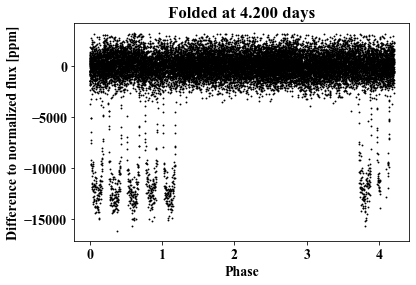

2019-12-08 18:23:55,502 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:23:55,521 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:23:55,521 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.
2019-12-08 18:23:55,996 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:23:56,012 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:23:56,015 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.


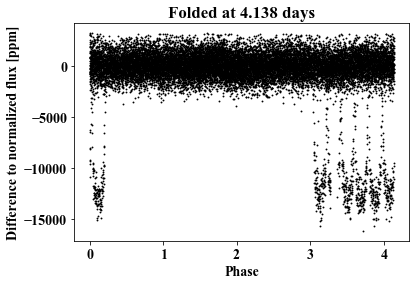

2019-12-08 18:23:56,596 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:23:56,615 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:23:56,616 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.
2019-12-08 18:23:57,083 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:23:57,099 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:23:57,100 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.


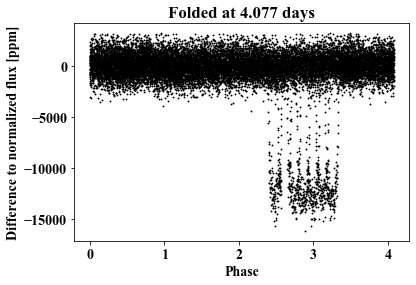

2019-12-08 18:23:57,680 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:23:57,699 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:23:57,700 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.
2019-12-08 18:23:58,166 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:23:58,184 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:23:58,184 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.


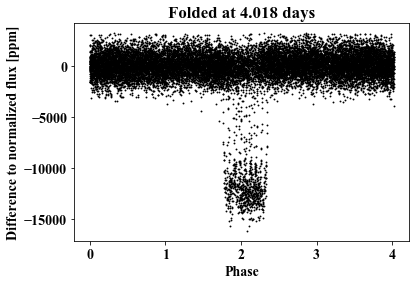

2019-12-08 18:23:58,765 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:23:58,784 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:23:58,785 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.
2019-12-08 18:23:59,256 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:23:59,273 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:23:59,273 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.


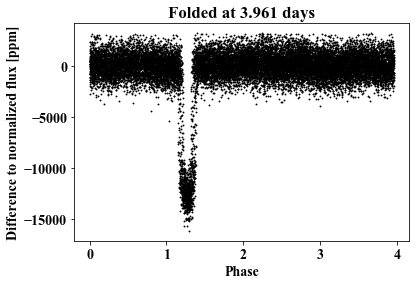

2019-12-08 18:23:59,860 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:23:59,879 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:23:59,880 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.
2019-12-08 18:24:00,350 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:00,367 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:00,368 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.


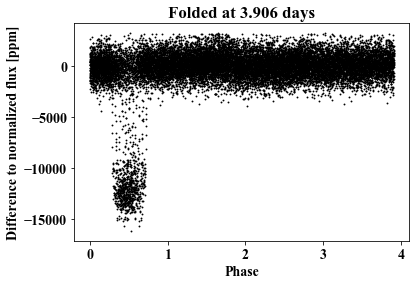

2019-12-08 18:24:00,958 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:00,976 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:00,977 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.
2019-12-08 18:24:01,447 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:01,465 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:01,465 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.


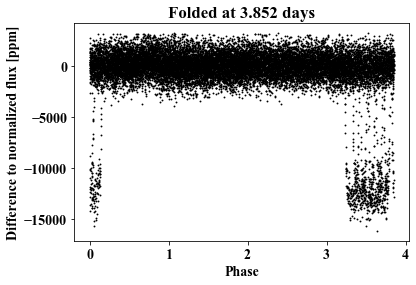

[4.2,
 4.1376374607581035,
 4.077099771591672,
 4.018307989481871,
 3.9611876601163045,
 3.9056685033252827,
 3.851684124605596]

In [11]:
lcTransit = lc.copy()
def gridfreq(lc,N=10):
    periods=[]
    phases=[]
    time = max(lc.time)-min(lc.time)
    for i in np.arange(1/4.2, 1/3.8, (1/time * 1/N)): #p 3.8 to 4.2
        period = 1/i
        phase = (lc.time % period)
        ##Outlier removal below
        flux_nomad = lc.flux-1
        mad = stats.median_absolute_deviation(flux_nomad)
        flux_mad = np.where(flux_nomad > 4*mad, 0, flux_nomad)
        ##Outlier removal above
        plt.scatter(phase, (flux_mad)*1e6, marker=".", color="k", s=3)
        plt.title("Folded at {} days".format('%.3f'%(period)))
        plt.xlabel("Phase")
        plt.ylabel("Difference to normalized flux [ppm]")
        plt.savefig(os.path.join(downloadDir,"PhaseFold_{}.pdf".format('%.3f'%(period))), bbox_inches='tight')
        plt.show()
        periods.append(period)
        phases.append(phase)
    return periods

gridfreq(lcTransit)

2019-12-08 18:24:01,845 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: Matching :family=Times New Roman:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2019-12-08 18:24:01,846 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:01,847 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:01,847 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:01,848 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:01,849 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 

2019-12-08 18:24:01,906 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Demi' (FRADM.TTF) normal normal demi normal>) = 10.24
2019-12-08 18:24:01,907 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Trebuchet MS' (trebucbi.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:01,909 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Rockwell Condensed' (ROCC____.TTF) normal normal 400 condensed>) = 10.25
2019-12-08 18:24:01,911 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Haettenschweiler' (HATTEN.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:01,912 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Book Antiqua' (ANTQUAB.TTF) normal normal book normal>) = 10.05
2019-12-08 18:24:01,916 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Californian FB' (CALIFI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:2

2019-12-08 18:24:01,978 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Fax' (LFAX.TTF) normal normal regular normal>) = 10.05
2019-12-08 18:24:01,979 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Playbill' (PLAYBILL.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:01,980 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Console' (lucon.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:01,981 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Colonna MT' (COLONNA.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:01,982 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Mongolian Baiti' (monbaiti.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:01,985 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century Gothic' (GOTHIC.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:01,990 DEBUG: matplotlib

2019-12-08 18:24:02,063 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Candara' (Candaral.ttf) normal normal light normal>) = 10.24
2019-12-08 18:24:02,065 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Constantia' (constanz.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:02,066 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Elephant' (ELEPHNT.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:02,068 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_CBI.TTF) italic normal bold condensed>) = 11.535
2019-12-08 18:24:02,069 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gill Sans MT' (GILB____.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:02,073 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gabriola' (Gabriola.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:02,074 DEBUG: matplotlib.f

2019-12-08 18:24:02,119 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans' (LSANS.TTF) normal normal regular normal>) = 10.05
2019-12-08 18:24:02,120 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Comic Sans MS' (comicz.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:02,121 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Sylfaen' (sylfaen.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:02,122 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Palatino Linotype' (pala.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:02,122 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calibri' (calibri.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:02,123 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Ebrima' (ebrimabd.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:02,124 DEBUG: matplotlib.font_m

2019-12-08 18:24:02,168 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Book' (FRABKIT.TTF) italic normal book normal>) = 11.05
2019-12-08 18:24:02,169 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Courier New' (couri.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:02,170 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Bright' (LBRITEI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:02,171 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (segoeuii.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:02,172 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tempus Sans ITC' (TEMPSITC.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:02,173 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'MS Outlook' (OUTLOOK.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:02,174 DEBUG: mat

2019-12-08 18:24:02,223 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'SimSun' (simsun.ttc) normal normal 400 normal>) = 10.05
2019-12-08 18:24:02,224 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bookshelf Symbol 7' (BSSYM7.TTF) normal normal book normal>) = 10.05
2019-12-08 18:24:02,224 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Georgia' (georgiai.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:02,225 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'High Tower Text' (HTOWERT.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:02,227 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_CR.TTF) normal normal 400 condensed>) = 10.25
2019-12-08 18:24:02,229 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Vivaldi' (VIVALDII.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:02,230 DEBUG: matplotlib.font_

2019-12-08 18:24:02,281 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Magneto' (MAGNETOB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:02,282 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century Schoolbook' (CENSCBK.TTF) normal normal book normal>) = 10.05
2019-12-08 18:24:02,282 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Goudy Old Style' (GOUDOSB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:02,283 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Niagara Engraved' (NIAGENG.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:02,285 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gadugi' (gadugi.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:02,286 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Arial Rounded MT Bold' (ARLRDBD.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:02,28

2019-12-08 18:24:02,340 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:02,341 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal bold normal>) = 1.335
2019-12-08 18:24:02,343 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:02,344 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:02,345 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:02,346 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 

2019-12-08 18:24:02,396 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century Schoolbook' (SCHLBKI.TTF) italic normal book normal>) = 11.05
2019-12-08 18:24:02,397 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bahnschrift' (bahnschrift.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:02,397 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (segoeuisl.ttf) normal normal light normal>) = 10.24
2019-12-08 18:24:02,398 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Myanmar Text' (mmrtextb.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:02,399 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gadugi' (gadugib.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:02,400 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bauhaus 93' (BAUHS93.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:02,402 DEBUG: ma

2019-12-08 18:24:02,449 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft Tai Le' (taile.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:02,450 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Wingdings 2' (WINGDNG2.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:02,452 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Courier New' (courbd.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:02,454 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Mistral' (MISTRAL.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:02,455 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calisto MT' (CALIST.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:02,455 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (seguisbi.ttf) italic normal semibold normal>) = 11.24
2019-12-08 18:24:02,456 DEBUG: matplotlib.fo

2019-12-08 18:24:02,510 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans Typewriter' (LTYPE.TTF) normal normal regular normal>) = 10.05
2019-12-08 18:24:02,512 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Palatino Linotype' (palabi.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:02,513 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Goudy Stout' (GOUDYSTO.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:02,514 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Wingdings' (wingding.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:02,515 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe Script' (segoescb.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:02,516 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bookman Old Style' (BOOKOSB.TTF) normal normal book normal>) = 10.05
2019-12-08 18:2

2019-12-08 18:24:02,564 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (seguibli.ttf) italic normal black normal>) = 11.525
2019-12-08 18:24:02,565 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Yu Gothic' (YuGothB.ttc) normal normal bold normal>) = 10.335
2019-12-08 18:24:02,566 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_BI.TTF) italic normal bold normal>) = 11.335
2019-12-08 18:24:02,566 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Handwriting' (LHANDW.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:02,568 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Times New Roman' (timesi.ttf) italic normal roman normal>) = 11.145
2019-12-08 18:24:02,570 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEBO.TTF) oblique normal bold normal>) = 11.335
2019-12-08 18:24:02,

2019-12-08 18:24:02,623 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'HoloLens MDL2 Assets' (holomdl2.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:02,623 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Baskerville Old Face' (BASKVILL.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:02,624 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tw Cen MT' (TCBI____.TTF) italic normal bold normal>) = 11.335
2019-12-08 18:24:02,625 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century Gothic' (GOTHICI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:02,627 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans' (LSANSD.TTF) normal normal roman normal>) = 10.145
2019-12-08 18:24:02,629 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Medium' (framd.ttf) normal normal medium normal>) = 10.145
2019-12

2019-12-08 18:24:02,681 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Arial' (ariali.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:02,682 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Palace Script MT' (PALSCRI.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:02,683 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Jokerman' (JOKERMAN.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:02,685 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Verdana' (verdanab.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:02,686 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Elephant' (ELEPHNTI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:02,688 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_PSTC.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:02,689 DEBUG: matplotlib.font_manager

2019-12-08 18:24:02,739 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Book Antiqua' (ANTQUABI.TTF) italic normal book normal>) = 11.05
2019-12-08 18:24:02,740 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Californian FB' (CALIFR.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:02,741 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Cambria' (cambriai.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:02,743 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Berlin Sans FB' (BRLNSB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:02,745 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Adobe Devanagari' (AdobeDevanagari-Regular.otf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:02,746 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Britannic Bold' (BRITANIC.TTF) normal normal bold normal>) = 10.335
2019-12-08 18

2019-12-08 18:24:02,813 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Copperplate Gothic Light' (COPRGTL.TTF) normal normal light normal>) = 11.24
2019-12-08 18:24:02,813 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Ink Free' (Inkfree.ttf) normal normal 400 normal>) = 11.05
2019-12-08 18:24:02,814 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Nirmala UI' (NirmalaS.ttf) normal normal light normal>) = 11.24
2019-12-08 18:24:02,815 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft Tai Le' (taileb.ttf) normal normal bold normal>) = 11.335
2019-12-08 18:24:02,816 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_BLAI.TTF) italic normal black normal>) = 10.525
2019-12-08 18:24:02,818 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calisto MT' (CALISTI.TTF) italic normal 400 normal>) = 10.05
2019-12-08 18:24:02,819 D

2019-12-08 18:24:02,870 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe MDL2 Assets' (segmdl2.ttf) normal normal 400 normal>) = 11.05
2019-12-08 18:24:02,871 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Nirmala UI' (NirmalaB.ttf) normal normal bold normal>) = 11.335
2019-12-08 18:24:02,872 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Leelawadee UI' (LeelawUI.ttf) normal normal 400 normal>) = 11.05
2019-12-08 18:24:02,873 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Modern No. 20' (MOD20.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:02,873 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Dubai' (DUBAI-MEDIUM.TTF) normal normal medium normal>) = 11.145
2019-12-08 18:24:02,874 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Dubai' (DUBAI-LIGHT.TTF) normal normal light normal>) = 11.24
2019-12-08 18:24:02,876 DEBUG: m

2019-12-08 18:24:02,922 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Consolas' (consolai.ttf) italic normal 400 normal>) = 10.05
2019-12-08 18:24:02,923 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft JhengHei' (msjhl.ttc) normal normal light normal>) = 11.24
2019-12-08 18:24:02,924 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bookman Old Style' (BOOKOSI.TTF) italic normal book normal>) = 10.05
2019-12-08 18:24:02,926 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Wingdings 3' (WINGDNG3.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:02,927 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gill Sans Ultra Bold' (GILSANUB.TTF) normal normal bold normal>) = 11.335
2019-12-08 18:24:02,929 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century Gothic' (GOTHICBI.TTF) italic normal bold normal>) = 10.335
2019-12-08 18:2

2019-12-08 18:24:02,980 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Comic Sans MS' (comicbd.ttf) normal normal bold normal>) = 11.335
2019-12-08 18:24:02,981 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans Unicode' (l_10646.ttf) normal normal 400 normal>) = 11.05
2019-12-08 18:24:02,982 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Perpetua' (PERBI___.TTF) italic normal bold normal>) = 10.335
2019-12-08 18:24:02,984 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Sitka Small' (SitkaB.ttc) normal normal bold normal>) = 11.335
2019-12-08 18:24:02,986 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_R.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:02,987 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Medium Cond' (FRAMDCN.TTF) normal normal medium condensed>) = 11.344999999999999
20

2019-12-08 18:24:03,040 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Californian FB' (CALIFB.TTF) normal normal bold normal>) = 11.335
2019-12-08 18:24:03,041 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Footlight MT Light' (FTLTLT.TTF) normal normal light normal>) = 11.24
2019-12-08 18:24:03,042 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Perpetua Titling MT' (PERTILI.TTF) normal normal light normal>) = 11.24
2019-12-08 18:24:03,043 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Ravie' (RAVIE.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:03,044 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe Print' (segoeprb.ttf) normal normal bold normal>) = 11.335
2019-12-08 18:24:03,045 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Matura MT Script Capitals' (MATURASC.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:

2019-12-08 18:24:03,096 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Nirmala UI' (Nirmala.ttf) normal normal 400 normal>) = 11.05
2019-12-08 18:24:03,097 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft Himalaya' (himalaya.ttf) normal normal 400 normal>) = 11.05
2019-12-08 18:24:03,098 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Agency FB' (AGENCYR.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:03,099 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Demi' (FRADMIT.TTF) italic normal demi normal>) = 10.24
2019-12-08 18:24:03,100 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'MS Reference Specialty' (REFSPCL.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:03,101 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'SimSun-ExtB' (simsunb.ttf) normal normal 400 normal>) = 11.05
2019-12-08 18:24:03,

2019-12-08 18:24:03,154 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI Emoji' (seguiemj.ttf) normal normal 400 normal>) = 11.05
2019-12-08 18:24:03,155 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Script MT Bold' (SCRIPTBL.TTF) normal normal bold normal>) = 11.335
2019-12-08 18:24:03,156 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Harrington' (HARNGTON.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:03,157 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Algerian' (ALGER.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:03,158 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Sitka Small' (SitkaI.ttc) italic normal 400 normal>) = 10.05
2019-12-08 18:24:03,160 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bookman Old Style' (BOOKOS.TTF) normal normal book normal>) = 11.05
2019-12-08 18:24:03,162 DEBUG: matpl

2019-12-08 18:24:03,224 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.335
2019-12-08 18:24:03,226 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.335
2019-12-08 18:24:03,227 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal bold normal>) = 11.0
2019-12-08 18:24:03,229 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal bold normal>) = 0.0
2019-12-08 18:24:03,230 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=bold:stretch=normal:size=14.0 to STIXGeneral ('D:\\Python\\Anaconda\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralBol.ttf') with 

2019-12-08 18:24:03,297 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft Tai Le' (taileb.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:03,298 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_BLAI.TTF) italic normal black normal>) = 11.525
2019-12-08 18:24:03,299 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calisto MT' (CALISTI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:03,300 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tw Cen MT Condensed' (TCCB____.TTF) normal normal bold condensed>) = 10.535
2019-12-08 18:24:03,302 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Trebuchet MS' (trebuc.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:03,304 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_BLAR.TTF) normal normal black normal>) = 10.525
2019-12-08 18:24:03,305

2019-12-08 18:24:03,355 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Modern No. 20' (MOD20.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:03,355 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Dubai' (DUBAI-MEDIUM.TTF) normal normal medium normal>) = 10.145
2019-12-08 18:24:03,356 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Dubai' (DUBAI-LIGHT.TTF) normal normal light normal>) = 10.24
2019-12-08 18:24:03,357 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Bright' (LBRITE.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:03,359 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Yu Gothic' (YuGothR.ttc) normal normal regular normal>) = 10.05
2019-12-08 18:24:03,360 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tw Cen MT Condensed Extra Bold' (TCCEB.TTF) normal normal bold condensed>) = 10.535
2019-12-08 18:24:0

2019-12-08 18:24:03,412 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Wingdings 3' (WINGDNG3.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:03,413 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gill Sans Ultra Bold' (GILSANUB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:03,414 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century Gothic' (GOTHICBI.TTF) italic normal bold normal>) = 11.335
2019-12-08 18:24:03,415 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Niagara Solid' (NIAGSOL.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:03,417 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bell MT' (BELLI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:03,418 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft YaHei' (msyh.ttc) normal normal 400 normal>) = 10.05
2019-12-08 18:24:03,420 DEBUG:

2019-12-08 18:24:03,465 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Sitka Small' (SitkaB.ttc) normal normal bold normal>) = 10.335
2019-12-08 18:24:03,466 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_R.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:03,468 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Medium Cond' (FRAMDCN.TTF) normal normal medium condensed>) = 10.344999999999999
2019-12-08 18:24:03,470 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Comic Sans MS' (comici.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:03,470 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calibri' (calibril.ttf) normal normal light normal>) = 10.24
2019-12-08 18:24:03,471 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Consolas' (consolaz.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:

2019-12-08 18:24:03,528 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Ravie' (RAVIE.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:03,529 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe Print' (segoeprb.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:03,530 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Matura MT Script Capitals' (MATURASC.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:03,531 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Fax' (LFAXDI.TTF) italic normal demibold normal>) = 11.24
2019-12-08 18:24:03,532 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Trebuchet MS' (trebucit.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:03,534 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Book Antiqua' (BKANT.TTF) normal normal book normal>) = 10.05
2019-12-08 18:24:03,536 DEBUG: 

2019-12-08 18:24:03,588 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Demi' (FRADMIT.TTF) italic normal demi normal>) = 11.24
2019-12-08 18:24:03,589 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'MS Reference Specialty' (REFSPCL.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:03,590 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'SimSun-ExtB' (simsunb.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:03,591 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft YaHei' (msyhl.ttc) normal normal light normal>) = 10.24
2019-12-08 18:24:03,593 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_B.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:03,595 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Symbol' (symbol.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:03,596 DEBUG

2019-12-08 18:24:03,653 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Algerian' (ALGER.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:03,654 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Sitka Small' (SitkaI.ttc) italic normal 400 normal>) = 11.05
2019-12-08 18:24:03,655 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bookman Old Style' (BOOKOS.TTF) normal normal book normal>) = 10.05
2019-12-08 18:24:03,656 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Onyx' (ONYX.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:03,657 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gill Sans MT' (GILBI___.TTF) italic normal bold normal>) = 11.335
2019-12-08 18:24:03,658 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_I.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:03,660 DEBUG: matplotlib.font_manager(_

2019-12-08 18:24:03,713 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal bold normal>) = 11.335
2019-12-08 18:24:03,714 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 11.05
2019-12-08 18:24:03,715 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 11.05
2019-12-08 18:24:03,716 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 11.05
2019-12-08 18:24:03,718 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal bold normal>) = 0.33499999999999996
2019-12-08 18:24:03,720 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf

2019-12-08 18:24:03,770 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'MingLiU-ExtB' (mingliub.ttc) normal normal 400 normal>) = 11.05
2019-12-08 18:24:03,770 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tw Cen MT' (TCMI____.TTF) italic normal 400 normal>) = 10.05
2019-12-08 18:24:03,771 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Eras Medium ITC' (ERASMD.TTF) normal normal medium normal>) = 11.145
2019-12-08 18:24:03,772 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Medium' (framdit.ttf) italic normal medium normal>) = 10.145
2019-12-08 18:24:03,773 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Showcard Gothic' (SHOWG.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:03,775 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Corbel' (corbelli.ttf) italic normal light normal>) = 10.24
2019-12-08 18:24:03,777

2019-12-08 18:24:03,829 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Fax' (LFAXI.TTF) italic normal 400 normal>) = 10.05
2019-12-08 18:24:03,830 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Monotype Corsiva' (MTCORSVA.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:03,831 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft New Tai Lue' (ntailub.ttf) normal normal bold normal>) = 11.335
2019-12-08 18:24:03,832 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Berlin Sans FB' (BRLNSR.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:03,834 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (seguisb.ttf) normal normal semibold normal>) = 11.24
2019-12-08 18:24:03,835 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Fax' (LFAXD.TTF) normal normal demibold normal>) = 11.24
2019-12-08 18:24:03,836 D

2019-12-08 18:24:03,886 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Eras Bold ITC' (ERASBD.TTF) normal normal bold normal>) = 11.335
2019-12-08 18:24:03,887 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (segoeuil.ttf) normal normal light normal>) = 11.24
2019-12-08 18:24:03,888 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Consolas' (consolab.ttf) normal normal bold normal>) = 11.335
2019-12-08 18:24:03,889 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tahoma' (tahoma.ttf) normal normal 400 normal>) = 11.05
2019-12-08 18:24:03,890 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Parchment' (PARCHM.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:03,892 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Perpetua' (PERI____.TTF) italic normal 400 normal>) = 10.05
2019-12-08 18:24:03,894 DEBUG: matplotlib.font_manager

2019-12-08 18:24:03,945 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Candara' (Candara.ttf) normal normal 400 normal>) = 11.05
2019-12-08 18:24:03,946 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Comic Sans MS' (comic.ttf) normal normal 400 normal>) = 11.05
2019-12-08 18:24:03,947 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'MT Extra' (MTEXTRA.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:03,947 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calibri' (calibrii.ttf) italic normal 400 normal>) = 10.05
2019-12-08 18:24:03,948 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Courier New' (courbi.ttf) italic normal bold normal>) = 10.335
2019-12-08 18:24:03,950 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Agency FB' (AGENCYB.TTF) normal normal bold normal>) = 11.335
2019-12-08 18:24:03,952 DEBUG: matplotlib.font_manager(

2019-12-08 18:24:04,003 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Kunstler Script' (KUNSTLER.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:04,003 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Old English Text MT' (OLDENGL.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:04,004 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Georgia' (georgiaz.ttf) italic normal bold normal>) = 10.335
2019-12-08 18:24:04,005 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Palatino Linotype' (palab.ttf) normal normal bold normal>) = 11.335
2019-12-08 18:24:04,006 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calisto MT' (CALISTBI.TTF) italic normal bold normal>) = 10.335
2019-12-08 18:24:04,007 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Book Antiqua' (ANTQUAI.TTF) italic normal book normal>) = 10.05
2019-12-08 18:24:04,009 

2019-12-08 18:24:04,063 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calibri' (calibrib.ttf) normal normal bold normal>) = 11.335
2019-12-08 18:24:04,064 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Leelawadee UI' (LeelUIsl.ttf) normal normal light normal>) = 11.24
2019-12-08 18:24:04,065 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Candara' (Candarab.ttf) normal normal bold normal>) = 11.335
2019-12-08 18:24:04,067 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century' (CENTURY.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:04,069 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Forte' (FORTE.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:04,070 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Malgun Gothic' (malgun.ttf) normal normal 400 normal>) = 11.05
2019-12-08 18:24:04,071 DEBUG: matplotlib.font_manager

2019-12-08 18:24:04,120 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'OCR A Extended' (OCRAEXT.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:04,121 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tahoma' (tahomabd.ttf) normal normal bold normal>) = 11.335
2019-12-08 18:24:04,121 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Garamond' (GARA.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:04,122 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Adobe Devanagari' (AdobeDevanagari-Italic.otf) italic normal 400 normal>) = 10.05
2019-12-08 18:24:04,123 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Brush Script MT' (BRUSHSCI.TTF) italic normal 400 normal>) = 10.05
2019-12-08 18:24:04,124 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Pristina' (PRISTINA.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:04,126 DEBU

2019-12-08 18:24:04,185 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,186 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:04,187 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,188 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:04,189 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,191 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05

2019-12-08 18:24:04,246 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Myanmar Text' (mmrtextb.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:04,247 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gadugi' (gadugib.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:04,248 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bauhaus 93' (BAUHS93.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,250 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Times New Roman' (timesbd.ttf) normal normal roman normal>) = 10.145
2019-12-08 18:24:04,252 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (seguisli.ttf) italic normal light normal>) = 11.24
2019-12-08 18:24:04,253 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe Script' (segoesc.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,254 DEBUG: matplot

2019-12-08 18:24:04,303 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Mistral' (MISTRAL.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,304 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calisto MT' (CALIST.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,305 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (seguisbi.ttf) italic normal semibold normal>) = 11.24
2019-12-08 18:24:04,306 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Constantia' (constan.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,308 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Corbel' (corbel.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,309 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Heavy' (FRAHVIT.TTF) italic normal heavy normal>) = 11.43
2019-12-08 18:24:04,311 DEBUG: matplotlib.fo

2019-12-08 18:24:04,365 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Goudy Stout' (GOUDYSTO.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,367 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Wingdings' (wingding.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,369 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe Script' (segoescb.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:04,370 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bookman Old Style' (BOOKOSB.TTF) normal normal book normal>) = 10.05
2019-12-08 18:24:04,371 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Rage Italic' (RAGE.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:04,372 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Stencil' (STENCIL.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,373 DEBUG: matplotlib.

2019-12-08 18:24:04,424 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_BI.TTF) italic normal bold normal>) = 11.335
2019-12-08 18:24:04,425 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Handwriting' (LHANDW.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:04,427 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Times New Roman' (timesi.ttf) italic normal roman normal>) = 11.145
2019-12-08 18:24:04,428 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEBO.TTF) oblique normal bold normal>) = 11.335
2019-12-08 18:24:04,429 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft JhengHei' (msjh.ttc) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,430 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Rockwell Extra Bold' (ROCKEB.TTF) normal normal bold normal>) = 10.335
2019-12-

2019-12-08 18:24:04,482 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tw Cen MT' (TCBI____.TTF) italic normal bold normal>) = 11.335
2019-12-08 18:24:04,484 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century Gothic' (GOTHICI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:04,486 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans' (LSANSD.TTF) normal normal roman normal>) = 10.145
2019-12-08 18:24:04,487 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Medium' (framd.ttf) normal normal medium normal>) = 10.145
2019-12-08 18:24:04,488 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans' (LSANSDI.TTF) italic normal demibold normal>) = 11.24
2019-12-08 18:24:04,488 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Eras Light ITC' (ERASLGHT.TTF) normal normal light normal>) = 10.24
2019-12-08 18:24

2019-12-08 18:24:04,548 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Verdana' (verdanab.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:04,549 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Elephant' (ELEPHNTI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:04,550 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_PSTC.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,551 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Cambria' (cambria.ttc) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,552 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Rockwell' (ROCKB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:04,553 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Arial' (ARIALNB.TTF) normal normal bold condensed>) = 10.535
2019-12-08 18:24:04,554 DEBUG: matplotlib.font_manager(_fi

2019-12-08 18:24:04,605 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Berlin Sans FB' (BRLNSB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:04,607 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Adobe Devanagari' (AdobeDevanagari-Regular.otf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,609 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Britannic Bold' (BRITANIC.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:04,611 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bahnschrift' (BAHNSCHRIFT_0.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,612 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: Matching :family=STIXSizeOneSym:style=normal:variant=normal:weight=normal:stretch=normal:size=14.0 to STIXSizeOneSym ('D:\\Python\\Anaconda\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizOneSymReg.ttf') with score of 0.050000.
2

2019-12-08 18:24:04,686 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft Tai Le' (taileb.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:04,687 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_BLAI.TTF) italic normal black normal>) = 11.525
2019-12-08 18:24:04,688 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calisto MT' (CALISTI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:04,689 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tw Cen MT Condensed' (TCCB____.TTF) normal normal bold condensed>) = 10.535
2019-12-08 18:24:04,689 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Trebuchet MS' (trebuc.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,691 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_BLAR.TTF) normal normal black normal>) = 10.525
2019-12-08 18:24:04,692

2019-12-08 18:24:04,742 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Modern No. 20' (MOD20.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,743 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Dubai' (DUBAI-MEDIUM.TTF) normal normal medium normal>) = 10.145
2019-12-08 18:24:04,745 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Dubai' (DUBAI-LIGHT.TTF) normal normal light normal>) = 10.24
2019-12-08 18:24:04,746 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Bright' (LBRITE.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,746 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Yu Gothic' (YuGothR.ttc) normal normal regular normal>) = 10.05
2019-12-08 18:24:04,747 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tw Cen MT Condensed Extra Bold' (TCCEB.TTF) normal normal bold condensed>) = 10.535
2019-12-08 18:24:0

2019-12-08 18:24:04,794 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Wingdings 3' (WINGDNG3.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,795 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gill Sans Ultra Bold' (GILSANUB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:04,796 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century Gothic' (GOTHICBI.TTF) italic normal bold normal>) = 11.335
2019-12-08 18:24:04,798 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Niagara Solid' (NIAGSOL.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,799 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bell MT' (BELLI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:04,801 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft YaHei' (msyh.ttc) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,802 DEBUG:

2019-12-08 18:24:04,858 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Sitka Small' (SitkaB.ttc) normal normal bold normal>) = 10.335
2019-12-08 18:24:04,860 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_R.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,861 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Medium Cond' (FRAMDCN.TTF) normal normal medium condensed>) = 10.344999999999999
2019-12-08 18:24:04,861 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Comic Sans MS' (comici.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:04,862 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calibri' (calibril.ttf) normal normal light normal>) = 10.24
2019-12-08 18:24:04,863 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Consolas' (consolaz.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:

2019-12-08 18:24:04,916 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Ravie' (RAVIE.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,918 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe Print' (segoeprb.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:04,919 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Matura MT Script Capitals' (MATURASC.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,920 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Fax' (LFAXDI.TTF) italic normal demibold normal>) = 11.24
2019-12-08 18:24:04,921 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Trebuchet MS' (trebucit.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:04,922 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Book Antiqua' (BKANT.TTF) normal normal book normal>) = 10.05
2019-12-08 18:24:04,923 DEBUG: 

2019-12-08 18:24:04,972 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Demi' (FRADMIT.TTF) italic normal demi normal>) = 11.24
2019-12-08 18:24:04,974 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'MS Reference Specialty' (REFSPCL.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,975 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'SimSun-ExtB' (simsunb.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,977 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft YaHei' (msyhl.ttc) normal normal light normal>) = 10.24
2019-12-08 18:24:04,978 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_B.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:04,979 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Symbol' (symbol.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:04,980 DEBUG

2019-12-08 18:24:05,029 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Algerian' (ALGER.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,030 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Sitka Small' (SitkaI.ttc) italic normal 400 normal>) = 11.05
2019-12-08 18:24:05,033 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bookman Old Style' (BOOKOS.TTF) normal normal book normal>) = 10.05
2019-12-08 18:24:05,035 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Onyx' (ONYX.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,036 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gill Sans MT' (GILBI___.TTF) italic normal bold normal>) = 11.335
2019-12-08 18:24:05,037 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_I.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:05,037 DEBUG: matplotlib.font_manager(_

2019-12-08 18:24:05,088 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:05,090 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXGeneral' (STIXGeneral.ttf) normal normal regular normal>) = 10.05
2019-12-08 18:24:05,092 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,094 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,095 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:05,095 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal norm

2019-12-08 18:24:05,145 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'MingLiU-ExtB' (mingliub.ttc) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,146 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tw Cen MT' (TCMI____.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:05,146 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Eras Medium ITC' (ERASMD.TTF) normal normal medium normal>) = 10.145
2019-12-08 18:24:05,147 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Medium' (framdit.ttf) italic normal medium normal>) = 11.145
2019-12-08 18:24:05,149 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Showcard Gothic' (SHOWG.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,150 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Corbel' (corbelli.ttf) italic normal light normal>) = 11.24
2019-12-08 18:24:05,151

2019-12-08 18:24:05,201 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Fax' (LFAXI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:05,202 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Monotype Corsiva' (MTCORSVA.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,204 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft New Tai Lue' (ntailub.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:05,204 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Berlin Sans FB' (BRLNSR.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,206 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (seguisb.ttf) normal normal semibold normal>) = 10.24
2019-12-08 18:24:05,208 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Fax' (LFAXD.TTF) normal normal demibold normal>) = 10.24
2019-12-08 18:24:05,209 D

2019-12-08 18:24:05,258 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Eras Bold ITC' (ERASBD.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:05,260 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (segoeuil.ttf) normal normal light normal>) = 10.24
2019-12-08 18:24:05,261 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Consolas' (consolab.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:05,262 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tahoma' (tahoma.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,263 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Parchment' (PARCHM.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,264 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Perpetua' (PERI____.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:05,266 DEBUG: matplotlib.font_manager

2019-12-08 18:24:05,317 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Candara' (Candara.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,318 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Comic Sans MS' (comic.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,319 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'MT Extra' (MTEXTRA.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,320 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calibri' (calibrii.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:05,321 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Courier New' (courbi.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:05,322 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Agency FB' (AGENCYB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:05,324 DEBUG: matplotlib.font_manager(

2019-12-08 18:24:05,380 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Kunstler Script' (KUNSTLER.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,382 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Old English Text MT' (OLDENGL.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,384 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Georgia' (georgiaz.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:05,384 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Palatino Linotype' (palab.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:05,385 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calisto MT' (CALISTBI.TTF) italic normal bold normal>) = 11.335
2019-12-08 18:24:05,386 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Book Antiqua' (ANTQUAI.TTF) italic normal book normal>) = 11.05
2019-12-08 18:24:05,387 

2019-12-08 18:24:05,444 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calibri' (calibrib.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:05,445 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Leelawadee UI' (LeelUIsl.ttf) normal normal light normal>) = 10.24
2019-12-08 18:24:05,446 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Candara' (Candarab.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:05,447 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century' (CENTURY.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,449 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Forte' (FORTE.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,451 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Malgun Gothic' (malgun.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,451 DEBUG: matplotlib.font_manager

2019-12-08 18:24:05,510 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'OCR A Extended' (OCRAEXT.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,511 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tahoma' (tahomabd.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:05,512 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Garamond' (GARA.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,513 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Adobe Devanagari' (AdobeDevanagari-Italic.otf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:05,514 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Brush Script MT' (BRUSHSCI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:05,516 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Pristina' (PRISTINA.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,517 DEBU

2019-12-08 18:24:05,564 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,566 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:05,567 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 0.05
2019-12-08 18:24:05,567 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal regular normal>) = 10.05
2019-12-08 18:24:05,568 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05
2019-12-08 18:24:05,569 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Palatino Linotype' (palai.ttf) italic normal 400 norm

2019-12-08 18:24:05,621 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Verdana' (verdanai.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:05,622 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Heavy' (FRAHV.TTF) normal normal heavy normal>) = 10.43
2019-12-08 18:24:05,624 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Viner Hand ITC' (VINERITC.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,627 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Berlin Sans FB Demi' (BRLNSDB.TTF) normal normal demi normal>) = 10.24
2019-12-08 18:24:05,628 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (seguibl.ttf) normal normal black normal>) = 10.525
2019-12-08 18:24:05,629 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'ROG Fonts' (ROGFonts-Regular.otf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05

2019-12-08 18:24:05,686 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Copperplate Gothic Bold' (COPRGTB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:05,687 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Engravers MT' (ENGR.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,688 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Dubai' (DUBAI-BOLD.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:05,691 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Maiandra GD' (MAIAN.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,693 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Leelawadee UI' (LeelaUIb.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:05,694 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Candara' (Candarali.ttf) italic normal light normal>) = 11.24
2019-12-08 18:24:05,695 DEBUG: m

2019-12-08 18:24:05,756 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Goudy Old Style' (GOUDOS.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,758 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEO.TTF) oblique normal 400 normal>) = 11.05
2019-12-08 18:24:05,760 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Ebrima' (ebrima.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,761 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Myanmar Text' (mmrtext.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,762 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Broadway' (BROADW.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,763 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calibri' (calibriz.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:05,763 DEBUG: matplotlib.

2019-12-08 18:24:05,819 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Times New Roman' (timesbi.ttf) italic normal roman normal>) = 11.145
2019-12-08 18:24:05,820 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Arial' (arialbi.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:05,821 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Open Sans' (OpenSans-Regular.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,822 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bell MT' (BELL.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,823 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Rockwell' (ROCKI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:05,825 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Eras Demi ITC' (ERASDEMI.TTF) normal normal demi normal>) = 10.24
2019-12-08 18:24:05,826 DEBUG: matplotlib.fo

2019-12-08 18:24:05,886 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Corbel' (corbelz.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:05,887 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft JhengHei' (msjhbd.ttc) normal normal bold normal>) = 10.335
2019-12-08 18:24:05,888 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Calligraphy' (LCALLIG.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:05,891 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Arial' (ARIALNBI.TTF) italic normal bold condensed>) = 11.535
2019-12-08 18:24:05,893 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (segoeui.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,894 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'MV Boli' (mvboli.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,894 DEBUG: matplotlib.

2019-12-08 18:24:05,953 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century Schoolbook' (SCHLBKBI.TTF) italic normal book normal>) = 11.05
2019-12-08 18:24:05,953 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bradley Hand ITC' (BRADHITC.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,955 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Book' (FRABK.TTF) normal normal book normal>) = 10.05
2019-12-08 18:24:05,958 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Webdings' (webdings.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:05,959 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Cambria' (cambriaz.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:05,960 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Edwardian Script ITC' (ITCEDSCR.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24

2019-12-08 18:24:06,017 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,018 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,019 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,020 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:06,021 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:06,021 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,023

2019-12-08 18:24:06,076 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans' (LSANSI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:06,077 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bernard MT Condensed' (BERNHC.TTF) normal normal 400 condensed>) = 10.25
2019-12-08 18:24:06,078 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Arial' (arial.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,079 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Castellar' (CASTELAR.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,081 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI Historic' (seguihis.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,083 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (segoeuib.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:06,085 DEBUG: matplot

2019-12-08 18:24:06,144 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Corbel' (corbell.ttf) normal normal light normal>) = 10.24
2019-12-08 18:24:06,145 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Dubai' (DUBAI-REGULAR.TTF) normal normal regular normal>) = 10.05
2019-12-08 18:24:06,146 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_CI.TTF) italic normal 400 condensed>) = 11.25
2019-12-08 18:24:06,147 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gill Sans MT' (GILI____.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:06,150 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bookman Old Style' (BOOKOSBI.TTF) italic normal book normal>) = 11.05
2019-12-08 18:24:06,151 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI Symbol' (seguisym.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,152 DEBUG:

2019-12-08 18:24:06,201 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Times New Roman' (times.ttf) normal normal roman normal>) = 10.145
2019-12-08 18:24:06,202 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Verdana' (verdana.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,203 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Corbel' (corbeli.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:06,204 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_CB.TTF) normal normal bold condensed>) = 10.535
2019-12-08 18:24:06,205 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Perpetua' (PER_____.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,206 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Yu Gothic' (YuGothM.ttc) normal normal medium normal>) = 10.145
2019-12-08 18:24:06,208 DEBUG: matplotlib.font_m

2019-12-08 18:24:06,260 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tw Cen MT' (TCM_____.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,261 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft Yi Baiti' (msyi.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,261 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Rockwell Condensed' (ROCCB___.TTF) normal normal bold condensed>) = 10.535
2019-12-08 18:24:06,262 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gill Sans MT' (GIL_____.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,263 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (seguili.ttf) italic normal light normal>) = 11.24
2019-12-08 18:24:06,263 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (segoeuiz.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:06,265 DEBUG

2019-12-08 18:24:06,317 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Georgia' (georgia.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,318 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calisto MT' (CALISTB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:06,319 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Bright' (LBRITEDI.TTF) italic normal demibold normal>) = 11.24
2019-12-08 18:24:06,320 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Garamond' (GARAIT.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:06,321 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Candara' (Candarai.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:06,322 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Imprint MT Shadow' (IMPRISHA.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,324 DEBUG: matplotlib

2019-12-08 18:24:06,375 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Poor Richard' (POORICH.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,376 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gill Sans MT Condensed' (GILC____.TTF) normal normal 400 condensed>) = 10.25
2019-12-08 18:24:06,377 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Open Sans' (OpenSans-Semibold.ttf) normal normal semibold normal>) = 10.24
2019-12-08 18:24:06,378 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Arial' (ARIALNI.TTF) italic normal 400 condensed>) = 11.25
2019-12-08 18:24:06,379 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tw Cen MT' (TCB_____.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:06,381 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Blackadder ITC' (ITCBLKAD.TTF) normal normal black normal>) = 10.525
2019-12-08 1

2019-12-08 18:24:06,433 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Trebuchet MS' (trebucbd.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:06,434 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'French Script MT' (FRSCRIPT.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,435 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century Gothic' (GOTHICB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:06,436 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bell MT' (BELLB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:06,437 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft New Tai Lue' (ntailu.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,438 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Courier New' (cour.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,439 DEBUG

2019-12-08 18:24:06,486 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:06,487 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,489 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
2019-12-08 18:24:06,490 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
2019-12-08 18:24:06,491 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:06,492 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) obli

2019-12-08 18:24:06,542 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Times New Roman' (timesbd.ttf) normal normal roman normal>) = 10.145
2019-12-08 18:24:06,542 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (seguisli.ttf) italic normal light normal>) = 11.24
2019-12-08 18:24:06,543 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe Script' (segoesc.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,544 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Juice ITC' (JUICE___.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,545 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Centaur' (CENTAUR.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,547 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Papyrus' (PAPYRUS.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,548 DEBUG: matplotlib.font_

2019-12-08 18:24:06,599 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Constantia' (constan.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,600 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Corbel' (corbel.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,601 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Heavy' (FRAHVIT.TTF) italic normal heavy normal>) = 11.43
2019-12-08 18:24:06,602 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Corbel' (corbelb.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:06,603 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Arial' (arialbd.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:06,604 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Goudy Old Style' (GOUDOSI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:06,606 DEBUG: matplotlib.fo

2019-12-08 18:24:06,658 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bookman Old Style' (BOOKOSB.TTF) normal normal book normal>) = 10.05
2019-12-08 18:24:06,659 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Rage Italic' (RAGE.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:06,660 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Stencil' (STENCIL.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,661 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Perpetua Titling MT' (PERTIBD.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:06,662 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tw Cen MT Condensed' (TCCM____.TTF) normal normal 400 condensed>) = 10.25
2019-12-08 18:24:06,663 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft PhagsPa' (phagspa.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:0

2019-12-08 18:24:06,715 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEBO.TTF) oblique normal bold normal>) = 11.335
2019-12-08 18:24:06,716 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft JhengHei' (msjh.ttc) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,717 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Rockwell Extra Bold' (ROCKEB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:06,718 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'MS Reference Sans Serif' (REFSAN.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,719 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Constantia' (constanb.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:06,720 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calibri' (calibrili.ttf) italic normal light normal>) = 11.24
2019-1

2019-12-08 18:24:06,773 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Medium' (framd.ttf) normal normal medium normal>) = 10.145
2019-12-08 18:24:06,775 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans' (LSANSDI.TTF) italic normal demibold normal>) = 11.24
2019-12-08 18:24:06,776 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Eras Light ITC' (ERASLGHT.TTF) normal normal light normal>) = 10.24
2019-12-08 18:24:06,777 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Garamond' (GARABD.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:06,778 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Georgia' (georgiab.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:06,779 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Consolas' (consola.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,781 DEBU

2019-12-08 18:24:06,835 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Cambria' (cambria.ttc) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,836 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Rockwell' (ROCKB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:06,836 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Arial' (ARIALNB.TTF) normal normal bold condensed>) = 10.535
2019-12-08 18:24:06,838 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Harlow Solid Italic' (HARLOWSI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:06,839 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Sitka Small' (Sitka.ttc) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,841 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Constantia' (constani.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:06,842 DEBUG: matplotlib.font_

2019-12-08 18:24:06,895 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bahnschrift' (BAHNSCHRIFT_0.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,897 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: Matching :family=cmsy10:style=normal:variant=normal:weight=normal:stretch=normal:size=14.0 to cmsy10 ('D:\\Python\\Anaconda\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmsy10.ttf') with score of 0.050000.
2019-12-08 18:24:06,916 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: Matching :family=cmr10:style=normal:variant=normal:weight=normal:stretch=normal:size=14.0.
2019-12-08 18:24:06,917 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,918 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:06,919 DEBUG

2019-12-08 18:24:06,973 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tw Cen MT Condensed' (TCCB____.TTF) normal normal bold condensed>) = 10.535
2019-12-08 18:24:06,974 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Trebuchet MS' (trebuc.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:06,975 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_BLAR.TTF) normal normal black normal>) = 10.525
2019-12-08 18:24:06,976 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Demi' (FRADM.TTF) normal normal demi normal>) = 10.24
2019-12-08 18:24:06,977 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Trebuchet MS' (trebucbi.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:06,978 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Rockwell Condensed' (ROCC____.TTF) normal normal 400 condensed>) = 10.25
2019-12

2019-12-08 18:24:07,033 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Bright' (LBRITE.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,034 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Yu Gothic' (YuGothR.ttc) normal normal regular normal>) = 10.05
2019-12-08 18:24:07,035 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tw Cen MT Condensed Extra Bold' (TCCEB.TTF) normal normal bold condensed>) = 10.535
2019-12-08 18:24:07,036 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Fax' (LFAX.TTF) normal normal regular normal>) = 10.05
2019-12-08 18:24:07,037 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Playbill' (PLAYBILL.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,038 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Console' (lucon.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,04

2019-12-08 18:24:07,090 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Niagara Solid' (NIAGSOL.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,091 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bell MT' (BELLI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:07,092 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft YaHei' (msyh.ttc) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,093 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Candara' (Candaral.ttf) normal normal light normal>) = 10.24
2019-12-08 18:24:07,094 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Constantia' (constanz.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:07,095 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Elephant' (ELEPHNT.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,097 DEBUG: matplotlib.font_mana

2019-12-08 18:24:07,146 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Comic Sans MS' (comici.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:07,148 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calibri' (calibril.ttf) normal normal light normal>) = 10.24
2019-12-08 18:24:07,150 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Consolas' (consolaz.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:07,150 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans' (LSANS.TTF) normal normal regular normal>) = 10.05
2019-12-08 18:24:07,151 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Comic Sans MS' (comicz.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:07,152 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Sylfaen' (sylfaen.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,153 DEBUG: matplotlib.fon

2019-12-08 18:24:07,203 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Fax' (LFAXDI.TTF) italic normal demibold normal>) = 11.24
2019-12-08 18:24:07,204 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Trebuchet MS' (trebucit.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:07,207 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Book Antiqua' (BKANT.TTF) normal normal book normal>) = 10.05
2019-12-08 18:24:07,209 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Book' (FRABKIT.TTF) italic normal book normal>) = 11.05
2019-12-08 18:24:07,209 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Courier New' (couri.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:07,209 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Bright' (LBRITEI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:07,210 DEBUG: 

2019-12-08 18:24:07,267 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft YaHei' (msyhl.ttc) normal normal light normal>) = 10.24
2019-12-08 18:24:07,267 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_B.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:07,268 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Symbol' (symbol.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,269 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'SimSun' (simsun.ttc) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,270 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bookshelf Symbol 7' (BSSYM7.TTF) normal normal book normal>) = 10.05
2019-12-08 18:24:07,272 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Georgia' (georgiai.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:07,273 DEBUG: matplotlib.font_manag

2019-12-08 18:24:07,330 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Onyx' (ONYX.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,331 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gill Sans MT' (GILBI___.TTF) italic normal bold normal>) = 11.335
2019-12-08 18:24:07,332 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_I.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:07,333 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Magneto' (MAGNETOB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:07,334 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century Schoolbook' (CENSCBK.TTF) normal normal book normal>) = 10.05
2019-12-08 18:24:07,335 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Goudy Old Style' (GOUDOSB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:07,335 DEBUG: matplotlib.f

2019-12-08 18:24:07,388 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Serif Display' (DejaVuSerifDisplay.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,389 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:07,390 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:07,391 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:07,392 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:07,393 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansM

2019-12-08 18:24:07,443 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Showcard Gothic' (SHOWG.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,444 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Corbel' (corbelli.ttf) italic normal light normal>) = 11.24
2019-12-08 18:24:07,445 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century Schoolbook' (SCHLBKI.TTF) italic normal book normal>) = 11.05
2019-12-08 18:24:07,447 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bahnschrift' (bahnschrift.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,448 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (segoeuisl.ttf) normal normal light normal>) = 10.24
2019-12-08 18:24:07,450 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Myanmar Text' (mmrtextb.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:07,451 DEBUG

2019-12-08 18:24:07,502 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (seguisb.ttf) normal normal semibold normal>) = 10.24
2019-12-08 18:24:07,502 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Fax' (LFAXD.TTF) normal normal demibold normal>) = 10.24
2019-12-08 18:24:07,503 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft Tai Le' (taile.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,505 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Wingdings 2' (WINGDNG2.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,506 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Courier New' (courbd.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:07,508 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Mistral' (MISTRAL.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,509 DEBUG: matplotlib

2019-12-08 18:24:07,560 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Perpetua' (PERI____.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:07,561 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft YaHei' (msyhbd.ttc) normal normal bold normal>) = 10.335
2019-12-08 18:24:07,562 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans Typewriter' (LTYPE.TTF) normal normal regular normal>) = 10.05
2019-12-08 18:24:07,564 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Palatino Linotype' (palabi.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:07,565 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Goudy Stout' (GOUDYSTO.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,566 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Wingdings' (wingding.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,567

2019-12-08 18:24:07,616 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Agency FB' (AGENCYB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:07,617 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Marlett' (marlett.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,618 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (seguibli.ttf) italic normal black normal>) = 11.525
2019-12-08 18:24:07,619 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Yu Gothic' (YuGothB.ttc) normal normal bold normal>) = 10.335
2019-12-08 18:24:07,620 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_BI.TTF) italic normal bold normal>) = 11.335
2019-12-08 18:24:07,621 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Handwriting' (LHANDW.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:07,623 DEBUG: matplotlib.fo

2019-12-08 18:24:07,675 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Book Antiqua' (ANTQUAI.TTF) italic normal book normal>) = 11.05
2019-12-08 18:24:07,675 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gloucester MT Extra Condensed' (GLECB.TTF) normal normal 400 condensed>) = 10.25
2019-12-08 18:24:07,676 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'HoloLens MDL2 Assets' (holomdl2.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,677 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Baskerville Old Face' (BASKVILL.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,678 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tw Cen MT' (TCBI____.TTF) italic normal bold normal>) = 11.335
2019-12-08 18:24:07,680 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century Gothic' (GOTHICI.TTF) italic normal 400 normal>) = 11.05
2

2019-12-08 18:24:07,736 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Malgun Gothic' (malgun.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,737 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Snap ITC' (SNAP____.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,739 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Arial' (ariali.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:07,739 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Palace Script MT' (PALSCRI.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,740 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Jokerman' (JOKERMAN.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,741 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Verdana' (verdanab.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:07,742 DEBUG: matplotlib.font_manag

2019-12-08 18:24:07,792 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Brush Script MT' (BRUSHSCI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:07,793 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Pristina' (PRISTINA.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,794 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Book Antiqua' (ANTQUABI.TTF) italic normal book normal>) = 11.05
2019-12-08 18:24:07,794 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Californian FB' (CALIFR.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,797 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Cambria' (cambriai.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:07,798 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Berlin Sans FB' (BRLNSB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:07,799 DEBUG: matplo

2019-12-08 18:24:07,845 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal regular normal>) = 10.05
2019-12-08 18:24:07,846 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Palatino Linotype' (palai.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:07,848 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Copperplate Gothic Light' (COPRGTL.TTF) normal normal light normal>) = 10.24
2019-12-08 18:24:07,850 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Ink Free' (Inkfree.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,851 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Nirmala UI' (NirmalaS.ttf) normal normal light normal>) = 10.24
2019-12-08 18:24:07,851 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft Tai Le' (taileb.ttf) normal normal bold normal>) = 10.335
20

2019-12-08 18:24:07,902 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (seguibl.ttf) normal normal black normal>) = 10.525
2019-12-08 18:24:07,903 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'ROG Fonts' (ROGFonts-Regular.otf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,904 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe MDL2 Assets' (segmdl2.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,906 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Nirmala UI' (NirmalaB.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:07,907 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Leelawadee UI' (LeelawUI.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,908 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Modern No. 20' (MOD20.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,909 DEBU

2019-12-08 18:24:07,960 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Leelawadee UI' (LeelaUIb.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:07,963 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Candara' (Candarali.ttf) italic normal light normal>) = 11.24
2019-12-08 18:24:07,963 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Consolas' (consolai.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:07,965 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft JhengHei' (msjhl.ttc) normal normal light normal>) = 10.24
2019-12-08 18:24:07,966 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bookman Old Style' (BOOKOSI.TTF) italic normal book normal>) = 11.05
2019-12-08 18:24:07,967 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Wingdings 3' (WINGDNG3.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:07,968 DEBU

2019-12-08 18:24:08,019 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Broadway' (BROADW.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,021 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calibri' (calibriz.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:08,023 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Comic Sans MS' (comicbd.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:08,024 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans Unicode' (l_10646.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,025 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Perpetua' (PERBI___.TTF) italic normal bold normal>) = 11.335
2019-12-08 18:24:08,026 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Sitka Small' (SitkaB.ttc) normal normal bold normal>) = 10.335
2019-12-08 18:24:08,027 DEBUG: matplot

2019-12-08 18:24:08,079 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Rockwell' (ROCKI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:08,080 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Eras Demi ITC' (ERASDEMI.TTF) normal normal demi normal>) = 10.24
2019-12-08 18:24:08,082 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Californian FB' (CALIFB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:08,083 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Footlight MT Light' (FTLTLT.TTF) normal normal light normal>) = 10.24
2019-12-08 18:24:08,084 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Perpetua Titling MT' (PERTILI.TTF) normal normal light normal>) = 10.24
2019-12-08 18:24:08,085 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Ravie' (RAVIE.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,086 DEBUG: ma

2019-12-08 18:24:08,137 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (segoeui.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,139 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'MV Boli' (mvboli.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,141 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Nirmala UI' (Nirmala.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,142 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft Himalaya' (himalaya.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,143 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Agency FB' (AGENCYR.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,144 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Demi' (FRADMIT.TTF) italic normal demi normal>) = 11.24
2019-12-08 18:24:08,145 DEBUG: matplotl

2019-12-08 18:24:08,197 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Cambria' (cambriaz.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:08,199 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Edwardian Script ITC' (ITCEDSCR.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,200 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI Emoji' (seguiemj.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,201 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Script MT Bold' (SCRIPTBL.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:08,202 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Harrington' (HARNGTON.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,203 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Algerian' (ALGER.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,204 DEBUG: m

2019-12-08 18:24:08,255 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:08,257 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,258 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05
2019-12-08 18:24:08,259 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymReg.ttf) normal normal regular normal>) = 10.05
2019-12-08 18:24:08,260 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2019-12-08 18:24:08,260 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXGeneral' (STI

2019-12-08 18:24:08,310 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI Historic' (seguihis.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,311 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (segoeuib.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:08,312 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gill Sans MT Ext Condensed Bold' (GLSNECB.TTF) normal normal bold condensed>) = 10.535
2019-12-08 18:24:08,314 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft PhagsPa' (phagspab.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:08,316 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Rockwell' (ROCK.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,317 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'MingLiU-ExtB' (mingliub.ttc) normal normal 400 normal>) = 10.05
2019-12-0

2019-12-08 18:24:08,366 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bookman Old Style' (BOOKOSBI.TTF) italic normal book normal>) = 11.05
2019-12-08 18:24:08,367 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI Symbol' (seguisym.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,368 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Javanese Text' (javatext.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,370 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Cooper Black' (COOPBL.TTF) normal normal black normal>) = 10.525
2019-12-08 18:24:08,371 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Rockwell' (ROCKBI.TTF) italic normal bold normal>) = 11.335
2019-12-08 18:24:08,372 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Fax' (LFAXI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:08,373 DEBUG: m

2019-12-08 18:24:08,424 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Perpetua' (PER_____.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,425 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Yu Gothic' (YuGothM.ttc) normal normal medium normal>) = 10.145
2019-12-08 18:24:08,426 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Wide Latin' (LATINWD.TTF) normal normal 400 expanded>) = 10.25
2019-12-08 18:24:08,427 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Candara' (Candaraz.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:08,428 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Informal Roman' (INFROMAN.TTF) normal normal roman normal>) = 10.145
2019-12-08 18:24:08,430 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Eras Bold ITC' (ERASBD.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:08,432 DEBUG: matpl

2019-12-08 18:24:08,484 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (seguili.ttf) italic normal light normal>) = 11.24
2019-12-08 18:24:08,485 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (segoeuiz.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:08,486 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Bright' (LBRITED.TTF) normal normal demibold normal>) = 10.24
2019-12-08 18:24:08,488 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Great Vibes' (GreatVibes-Regular.otf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,488 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe Print' (segoepr.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,489 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Candara' (Candara.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,490 DEBUG: ma

2019-12-08 18:24:08,538 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Candara' (Candarai.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:08,539 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Imprint MT Shadow' (IMPRISHA.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,540 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Adobe Devanagari' (AdobeDevanagari-BoldItalic.otf) italic normal bold normal>) = 11.335
2019-12-08 18:24:08,541 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'High Tower Text' (HTOWERTI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:08,542 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Impact' (impact.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,543 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Kunstler Script' (KUNSTLER.TTF) normal normal 400 normal>) = 10.05
2019-12-08 1

2019-12-08 18:24:08,592 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tw Cen MT' (TCB_____.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:08,593 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Blackadder ITC' (ITCBLKAD.TTF) normal normal black normal>) = 10.525
2019-12-08 18:24:08,594 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Chiller' (CHILLER.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,595 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gigi' (GIGI.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,597 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Curlz MT' (CURLZ___.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,599 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calibri' (calibrib.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:08,599 DEBUG: matplotlib.font_manager(

2019-12-08 18:24:08,642 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft New Tai Lue' (ntailu.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,643 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Courier New' (cour.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,643 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Yu Gothic' (YuGothL.ttc) normal normal light normal>) = 10.24
2019-12-08 18:24:08,644 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:08,645 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Arial' (ARIALN.TTF) normal normal 400 condensed>) = 10.25
2019-12-08 18:24:08,647 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'OCR A Extended' (OCRAEXT.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,648 DEBUG

2019-12-08 18:24:08,698 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:08,699 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2019-12-08 18:24:08,700 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:08,701 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 11.05
2019-12-08 18:24:08,702 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,703 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400

2019-12-08 18:24:08,752 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Centaur' (CENTAUR.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,753 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Papyrus' (PAPYRUS.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,754 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Vladimir Script' (VLADIMIR.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,755 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Freestyle Script' (FREESCPT.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,756 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Verdana' (verdanaz.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:08,757 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Verdana' (verdanai.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:08,758 DEBUG: matplotlib.font_

2019-12-08 18:24:08,810 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Arial' (arialbd.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:08,811 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Goudy Old Style' (GOUDOSI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:08,813 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Demi Cond' (FRADMCN.TTF) normal normal demi condensed>) = 10.44
2019-12-08 18:24:08,815 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century Schoolbook' (SCHLBKB.TTF) normal normal book normal>) = 10.05
2019-12-08 18:24:08,815 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Sitka Small' (SitkaZ.ttc) italic normal bold normal>) = 11.335
2019-12-08 18:24:08,816 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Copperplate Gothic Bold' (COPRGTB.TTF) normal normal bold normal>) = 10.335
2019-

2019-12-08 18:24:08,867 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tw Cen MT Condensed' (TCCM____.TTF) normal normal 400 condensed>) = 10.25
2019-12-08 18:24:08,868 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft PhagsPa' (phagspa.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,868 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Adobe Devanagari' (AdobeDevanagari-Bold.otf) normal normal bold normal>) = 10.335
2019-12-08 18:24:08,869 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Felix Titling' (FELIXTI.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,871 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Malgun Gothic' (malgunbd.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:08,873 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Goudy Old Style' (GOUDOS.TTF) normal normal 400 normal>) = 10.0

2019-12-08 18:24:08,926 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Constantia' (constanb.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:08,927 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calibri' (calibrili.ttf) italic normal light normal>) = 11.24
2019-12-08 18:24:08,929 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Arial' (ariblk.ttf) normal normal black normal>) = 10.525
2019-12-08 18:24:08,931 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Cambria' (cambriab.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:08,932 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Kristen ITC' (ITCKRIST.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,933 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Times New Roman' (timesbi.ttf) italic normal roman normal>) = 11.145
2019-12-08 18:24:08,934 DEBUG: matplotlib

2019-12-08 18:24:08,984 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Georgia' (georgiab.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:08,985 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Consolas' (consola.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,987 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'MS Gothic' (msgothic.ttc) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,988 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'ZWAdobeF' (ZWAdobeF.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:08,990 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gill Sans Ultra Bold Condensed' (GILLUBCD.TTF) normal normal bold condensed>) = 10.535
2019-12-08 18:24:08,991 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Corbel' (corbelz.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:08,992 DEBUG: 

2019-12-08 18:24:09,044 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Sitka Small' (Sitka.ttc) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,045 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Constantia' (constani.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:09,046 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Perpetua' (PERB____.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:09,047 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft Sans Serif' (micross.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,048 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Malgun Gothic' (malgunsl.ttf) normal normal light normal>) = 10.24
2019-12-08 18:24:09,049 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century Schoolbook' (SCHLBKBI.TTF) italic normal book normal>) = 11.05
2019-12-08 18:24:09,050 D

2019-12-08 18:24:09,099 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,100 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:09,101 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 0.05
2019-12-08 18:24:09,102 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:09,104 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:09,105 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,106 DEB

2019-12-08 18:24:09,154 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Trebuchet MS' (trebucbi.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:09,155 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Rockwell Condensed' (ROCC____.TTF) normal normal 400 condensed>) = 10.25
2019-12-08 18:24:09,156 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Haettenschweiler' (HATTEN.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,157 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Book Antiqua' (ANTQUAB.TTF) normal normal book normal>) = 10.05
2019-12-08 18:24:09,158 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Californian FB' (CALIFI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:09,159 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans' (LSANSI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:09,161 

2019-12-08 18:24:09,218 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Playbill' (PLAYBILL.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,218 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Console' (lucon.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,220 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Colonna MT' (COLONNA.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,221 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Mongolian Baiti' (monbaiti.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,222 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century Gothic' (GOTHIC.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,223 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Corbel' (corbell.ttf) normal normal light normal>) = 10.24
2019-12-08 18:24:09,225 DEBUG: matplotlib.fo

2019-12-08 18:24:09,274 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Constantia' (constanz.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:09,275 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Elephant' (ELEPHNT.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,276 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_CBI.TTF) italic normal bold condensed>) = 11.535
2019-12-08 18:24:09,278 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gill Sans MT' (GILB____.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:09,279 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gabriola' (Gabriola.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,281 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Times New Roman' (times.ttf) normal normal roman normal>) = 10.145
2019-12-08 18:24:09,282 DEBUG: matplo

2019-12-08 18:24:09,329 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Comic Sans MS' (comicz.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:09,330 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Sylfaen' (sylfaen.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,330 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Palatino Linotype' (pala.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,331 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calibri' (calibri.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,332 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Ebrima' (ebrimabd.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:09,333 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tw Cen MT' (TCM_____.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,334 DEBUG: matplotlib.font_mana

2019-12-08 18:24:09,383 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Courier New' (couri.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:09,383 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Bright' (LBRITEI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:09,384 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (segoeuii.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:09,385 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tempus Sans ITC' (TEMPSITC.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,387 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'MS Outlook' (OUTLOOK.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,388 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Georgia' (georgia.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,390 DEBUG: matplotlib.font_m

2019-12-08 18:24:09,441 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bookshelf Symbol 7' (BSSYM7.TTF) normal normal book normal>) = 10.05
2019-12-08 18:24:09,442 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Georgia' (georgiai.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:09,443 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'High Tower Text' (HTOWERT.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,445 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_CR.TTF) normal normal 400 condensed>) = 10.25
2019-12-08 18:24:09,447 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Vivaldi' (VIVALDII.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:09,448 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Poor Richard' (POORICH.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,449 DEBUG: matplotli

2019-12-08 18:24:09,500 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century Schoolbook' (CENSCBK.TTF) normal normal book normal>) = 10.05
2019-12-08 18:24:09,501 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Goudy Old Style' (GOUDOSB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:09,502 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Niagara Engraved' (NIAGENG.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,503 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gadugi' (gadugi.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,504 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Arial Rounded MT Bold' (ARLRDBD.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:09,505 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Trebuchet MS' (trebucbd.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:

2019-12-08 18:24:09,551 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:09,552 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:09,554 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,556 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:09,557 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,557 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 norma

2019-12-08 18:24:09,608 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bahnschrift' (bahnschrift.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,609 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (segoeuisl.ttf) normal normal light normal>) = 10.24
2019-12-08 18:24:09,610 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Myanmar Text' (mmrtextb.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:09,612 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gadugi' (gadugib.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:09,614 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bauhaus 93' (BAUHS93.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,615 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Times New Roman' (timesbd.ttf) normal normal roman normal>) = 10.145
2019-12-08 18:24:09,616 DEBUG: mat

2019-12-08 18:24:09,666 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Wingdings 2' (WINGDNG2.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,667 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Courier New' (courbd.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:09,668 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Mistral' (MISTRAL.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,669 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calisto MT' (CALIST.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,671 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (seguisbi.ttf) italic normal semibold normal>) = 11.24
2019-12-08 18:24:09,673 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Constantia' (constan.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,674 DEBUG: matplotlib.font_m

2019-12-08 18:24:09,726 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Palatino Linotype' (palabi.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:09,727 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Goudy Stout' (GOUDYSTO.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,728 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Wingdings' (wingding.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,729 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe Script' (segoescb.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:09,730 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bookman Old Style' (BOOKOSB.TTF) normal normal book normal>) = 10.05
2019-12-08 18:24:09,731 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Rage Italic' (RAGE.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:09,732 DEBUG: 

2019-12-08 18:24:09,782 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Yu Gothic' (YuGothB.ttc) normal normal bold normal>) = 10.335
2019-12-08 18:24:09,783 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_BI.TTF) italic normal bold normal>) = 11.335
2019-12-08 18:24:09,784 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Handwriting' (LHANDW.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:09,784 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Times New Roman' (timesi.ttf) italic normal roman normal>) = 11.145
2019-12-08 18:24:09,786 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEBO.TTF) oblique normal bold normal>) = 11.335
2019-12-08 18:24:09,788 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft JhengHei' (msjh.ttc) normal normal 400 normal>) = 10.05
2019-12-08 18:24:

2019-12-08 18:24:09,841 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Baskerville Old Face' (BASKVILL.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,842 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tw Cen MT' (TCBI____.TTF) italic normal bold normal>) = 11.335
2019-12-08 18:24:09,843 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century Gothic' (GOTHICI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:09,845 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans' (LSANSD.TTF) normal normal roman normal>) = 10.145
2019-12-08 18:24:09,846 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Medium' (framd.ttf) normal normal medium normal>) = 10.145
2019-12-08 18:24:09,847 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans' (LSANSDI.TTF) italic normal demibold normal>) = 11.24
2019-12-08 1

2019-12-08 18:24:09,898 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Jokerman' (JOKERMAN.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,898 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Verdana' (verdanab.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:09,899 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Elephant' (ELEPHNTI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:09,900 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_PSTC.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,901 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Cambria' (cambria.ttc) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,903 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Rockwell' (ROCKB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:09,905 DEBUG: matplotlib.font_manager(_fin

2019-12-08 18:24:09,956 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Cambria' (cambriai.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:09,957 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Berlin Sans FB' (BRLNSB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:09,958 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Adobe Devanagari' (AdobeDevanagari-Regular.otf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,959 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Britannic Bold' (BRITANIC.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:09,960 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bahnschrift' (BAHNSCHRIFT_0.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:09,962 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: Matching :family=DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:s

2019-12-08 18:24:10,007 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Nirmala UI' (NirmalaS.ttf) normal normal light normal>) = 11.24
2019-12-08 18:24:10,007 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft Tai Le' (taileb.ttf) normal normal bold normal>) = 11.335
2019-12-08 18:24:10,008 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_BLAI.TTF) italic normal black normal>) = 10.525
2019-12-08 18:24:10,009 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calisto MT' (CALISTI.TTF) italic normal 400 normal>) = 10.05
2019-12-08 18:24:10,011 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tw Cen MT Condensed' (TCCB____.TTF) normal normal bold condensed>) = 11.535
2019-12-08 18:24:10,012 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Trebuchet MS' (trebuc.ttf) normal normal 400 normal>) = 11.05
2019-12-08 18:24:10,014

2019-12-08 18:24:10,058 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Leelawadee UI' (LeelawUI.ttf) normal normal 400 normal>) = 11.05
2019-12-08 18:24:10,059 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Modern No. 20' (MOD20.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:10,061 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Dubai' (DUBAI-MEDIUM.TTF) normal normal medium normal>) = 11.145
2019-12-08 18:24:10,063 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Dubai' (DUBAI-LIGHT.TTF) normal normal light normal>) = 11.24
2019-12-08 18:24:10,064 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Bright' (LBRITE.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:10,065 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Yu Gothic' (YuGothR.ttc) normal normal regular normal>) = 11.05
2019-12-08 18:24:10,066 DEBUG: matplo

2019-12-08 18:24:10,114 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bookman Old Style' (BOOKOSI.TTF) italic normal book normal>) = 10.05
2019-12-08 18:24:10,115 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Wingdings 3' (WINGDNG3.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:10,116 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gill Sans Ultra Bold' (GILSANUB.TTF) normal normal bold normal>) = 11.335
2019-12-08 18:24:10,117 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century Gothic' (GOTHICBI.TTF) italic normal bold normal>) = 10.335
2019-12-08 18:24:10,118 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Niagara Solid' (NIAGSOL.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:10,119 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bell MT' (BELLI.TTF) italic normal 400 normal>) = 10.05
2019-12-08 18:24:10,120 

2019-12-08 18:24:10,169 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Perpetua' (PERBI___.TTF) italic normal bold normal>) = 10.335
2019-12-08 18:24:10,171 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Sitka Small' (SitkaB.ttc) normal normal bold normal>) = 11.335
2019-12-08 18:24:10,172 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_R.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:10,173 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Medium Cond' (FRAMDCN.TTF) normal normal medium condensed>) = 11.344999999999999
2019-12-08 18:24:10,174 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Comic Sans MS' (comici.ttf) italic normal 400 normal>) = 10.05
2019-12-08 18:24:10,175 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calibri' (calibril.ttf) normal normal light normal>) = 11.24
2019-12-08 18:

2019-12-08 18:24:10,228 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Perpetua Titling MT' (PERTILI.TTF) normal normal light normal>) = 11.24
2019-12-08 18:24:10,230 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Ravie' (RAVIE.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:10,230 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe Print' (segoeprb.ttf) normal normal bold normal>) = 11.335
2019-12-08 18:24:10,232 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Matura MT Script Capitals' (MATURASC.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:10,233 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Fax' (LFAXDI.TTF) italic normal demibold normal>) = 10.24
2019-12-08 18:24:10,234 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Trebuchet MS' (trebucit.ttf) italic normal 400 normal>) = 10.05
2019-12-08 18:24:10,2

2019-12-08 18:24:10,289 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Agency FB' (AGENCYR.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:10,290 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Demi' (FRADMIT.TTF) italic normal demi normal>) = 10.24
2019-12-08 18:24:10,291 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'MS Reference Specialty' (REFSPCL.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:10,292 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'SimSun-ExtB' (simsunb.ttf) normal normal 400 normal>) = 11.05
2019-12-08 18:24:10,294 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft YaHei' (msyhl.ttc) normal normal light normal>) = 11.24
2019-12-08 18:24:10,295 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_B.TTF) normal normal bold normal>) = 11.335
2019-12-08 18:24:10,296 D

2019-12-08 18:24:10,345 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Harrington' (HARNGTON.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:10,346 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Algerian' (ALGER.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:10,347 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Sitka Small' (SitkaI.ttc) italic normal 400 normal>) = 10.05
2019-12-08 18:24:10,348 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bookman Old Style' (BOOKOS.TTF) normal normal book normal>) = 11.05
2019-12-08 18:24:10,349 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Onyx' (ONYX.TTF) normal normal 400 normal>) = 11.05
2019-12-08 18:24:10,350 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gill Sans MT' (GILBI___.TTF) italic normal bold normal>) = 10.335
2019-12-08 18:24:10,351 DEBUG: matplotlib.font_manag

2019-12-08 18:24:10,405 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:10,406 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:10,407 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:10,408 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:10,409 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:10,411 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal regular normal>) = 10.05

2019-12-08 18:24:10,458 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bernard MT Condensed' (BERNHC.TTF) normal normal 400 condensed>) = 10.25
2019-12-08 18:24:10,460 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Arial' (arial.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:10,461 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Castellar' (CASTELAR.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:10,463 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI Historic' (seguihis.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:10,464 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (segoeuib.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:10,465 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gill Sans MT Ext Condensed Bold' (GLSNECB.TTF) normal normal bold condensed>) = 10.535
2019-12-08 1

2019-12-08 18:24:10,517 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Dubai' (DUBAI-REGULAR.TTF) normal normal regular normal>) = 10.05
2019-12-08 18:24:10,518 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_CI.TTF) italic normal 400 condensed>) = 11.25
2019-12-08 18:24:10,520 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gill Sans MT' (GILI____.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:10,521 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bookman Old Style' (BOOKOSBI.TTF) italic normal book normal>) = 11.05
2019-12-08 18:24:10,522 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI Symbol' (seguisym.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:10,522 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Javanese Text' (javatext.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:10,523 

2019-12-08 18:24:10,574 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Verdana' (verdana.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:10,575 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Corbel' (corbeli.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:10,575 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_CB.TTF) normal normal bold condensed>) = 10.535
2019-12-08 18:24:10,577 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Perpetua' (PER_____.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:10,578 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Yu Gothic' (YuGothM.ttc) normal normal medium normal>) = 10.145
2019-12-08 18:24:10,578 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Wide Latin' (LATINWD.TTF) normal normal 400 expanded>) = 10.25
2019-12-08 18:24:10,579 DEBUG: matplotlib.font_manag

2019-12-08 18:24:10,630 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft Yi Baiti' (msyi.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:10,631 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Rockwell Condensed' (ROCCB___.TTF) normal normal bold condensed>) = 10.535
2019-12-08 18:24:10,632 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gill Sans MT' (GIL_____.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:10,633 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (seguili.ttf) italic normal light normal>) = 11.24
2019-12-08 18:24:10,635 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (segoeuiz.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:10,637 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Bright' (LBRITED.TTF) normal normal demibold normal>) = 10.24
2019-12-08 18:24:10,6

2019-12-08 18:24:10,689 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calisto MT' (CALISTB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:10,690 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Bright' (LBRITEDI.TTF) italic normal demibold normal>) = 11.24
2019-12-08 18:24:10,691 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Garamond' (GARAIT.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:10,692 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Candara' (Candarai.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:10,693 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Imprint MT Shadow' (IMPRISHA.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:10,694 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Adobe Devanagari' (AdobeDevanagari-BoldItalic.otf) italic normal bold normal>) = 11.335
2019-12-08 

2019-12-08 18:24:10,739 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gill Sans MT Condensed' (GILC____.TTF) normal normal 400 condensed>) = 10.25
2019-12-08 18:24:10,739 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Open Sans' (OpenSans-Semibold.ttf) normal normal semibold normal>) = 10.24
2019-12-08 18:24:10,740 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Arial' (ARIALNI.TTF) italic normal 400 condensed>) = 11.25
2019-12-08 18:24:10,741 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tw Cen MT' (TCB_____.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:10,742 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Blackadder ITC' (ITCBLKAD.TTF) normal normal black normal>) = 10.525
2019-12-08 18:24:10,744 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Chiller' (CHILLER.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:

2019-12-08 18:24:10,798 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'French Script MT' (FRSCRIPT.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:10,799 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century Gothic' (GOTHICB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:10,799 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bell MT' (BELLB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:10,800 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft New Tai Lue' (ntailu.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:10,801 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Courier New' (cour.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:10,803 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Yu Gothic' (YuGothL.ttc) normal normal light normal>) = 10.24
2019-12-08 18:24:10,804 DEBUG: ma

2019-12-08 18:24:10,850 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:10,852 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
2019-12-08 18:24:10,853 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
2019-12-08 18:24:10,855 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:10,856 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal bold normal>) = 11.335
2019-12-08 18:24:10,857 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.tt

2019-12-08 18:24:10,908 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (seguisli.ttf) italic normal light normal>) = 11.24
2019-12-08 18:24:10,908 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe Script' (segoesc.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:10,909 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Juice ITC' (JUICE___.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:10,911 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Centaur' (CENTAUR.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:10,913 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Papyrus' (PAPYRUS.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:10,914 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Vladimir Script' (VLADIMIR.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:10,915 DEBUG: matplotlib.font_ma

2019-12-08 18:24:10,962 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Corbel' (corbel.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:10,963 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Heavy' (FRAHVIT.TTF) italic normal heavy normal>) = 11.43
2019-12-08 18:24:10,964 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Corbel' (corbelb.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:10,965 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Arial' (arialbd.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:10,966 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Goudy Old Style' (GOUDOSI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:10,968 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Demi Cond' (FRADMCN.TTF) normal normal demi condensed>) = 10.44
2019-12-08 18:24:10,970 D

2019-12-08 18:24:11,019 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Rage Italic' (RAGE.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:11,020 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Stencil' (STENCIL.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:11,021 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Perpetua Titling MT' (PERTIBD.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:11,022 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tw Cen MT Condensed' (TCCM____.TTF) normal normal 400 condensed>) = 10.25
2019-12-08 18:24:11,022 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft PhagsPa' (phagspa.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:11,023 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Adobe Devanagari' (AdobeDevanagari-Bold.otf) normal normal bold normal>) = 10.335
2019-

2019-12-08 18:24:11,070 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft JhengHei' (msjh.ttc) normal normal 400 normal>) = 10.05
2019-12-08 18:24:11,071 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Rockwell Extra Bold' (ROCKEB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:11,072 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'MS Reference Sans Serif' (REFSAN.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:11,073 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Constantia' (constanb.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:11,074 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calibri' (calibrili.ttf) italic normal light normal>) = 11.24
2019-12-08 18:24:11,075 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Arial' (ariblk.ttf) normal normal black normal>) = 10.525
2019-12-08 18:24:11,076 

2019-12-08 18:24:11,129 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans' (LSANSDI.TTF) italic normal demibold normal>) = 11.24
2019-12-08 18:24:11,130 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Eras Light ITC' (ERASLGHT.TTF) normal normal light normal>) = 10.24
2019-12-08 18:24:11,131 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Garamond' (GARABD.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:11,132 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Georgia' (georgiab.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:11,132 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Consolas' (consola.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:11,133 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'MS Gothic' (msgothic.ttc) normal normal 400 normal>) = 10.05
2019-12-08 18:24:11,135 DEBUG: matplotlib.

2019-12-08 18:24:11,181 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Rockwell' (ROCKB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:11,182 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Arial' (ARIALNB.TTF) normal normal bold condensed>) = 10.535
2019-12-08 18:24:11,183 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Harlow Solid Italic' (HARLOWSI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:11,185 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Sitka Small' (Sitka.ttc) normal normal 400 normal>) = 10.05
2019-12-08 18:24:11,186 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Constantia' (constani.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:11,188 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Perpetua' (PERB____.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:11,189 DEBUG: matplotlib.f

2019-12-08 18:24:11,237 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: Matching :family=DejaVu Sans Display:style=normal:variant=normal:weight=normal:stretch=normal:size=14.0 to DejaVu Sans Display ('D:\\Python\\Anaconda\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansDisplay.ttf') with score of 0.050000.
2019-12-08 18:24:11,363 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: Matching :family=Times New Roman:style=normal:variant=normal:weight=normal:stretch=normal:size=15.0.
2019-12-08 18:24:11,364 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:11,364 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal bold normal>) = 10.335
2019-12-08 18:24:11,365 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 

2019-12-08 18:24:11,404 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Trebuchet MS' (trebuc.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:11,405 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_BLAR.TTF) normal normal black normal>) = 10.525
2019-12-08 18:24:11,406 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Demi' (FRADM.TTF) normal normal demi normal>) = 10.24
2019-12-08 18:24:11,406 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Trebuchet MS' (trebucbi.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:11,407 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Rockwell Condensed' (ROCC____.TTF) normal normal 400 condensed>) = 10.25
2019-12-08 18:24:11,408 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Haettenschweiler' (HATTEN.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:

2019-12-08 18:24:11,457 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Yu Gothic' (YuGothR.ttc) normal normal regular normal>) = 10.05
2019-12-08 18:24:11,457 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Tw Cen MT Condensed Extra Bold' (TCCEB.TTF) normal normal bold condensed>) = 10.535
2019-12-08 18:24:11,458 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Fax' (LFAX.TTF) normal normal regular normal>) = 10.05
2019-12-08 18:24:11,460 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Playbill' (PLAYBILL.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:11,461 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Console' (lucon.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:11,462 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Colonna MT' (COLONNA.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:11,463 

2019-12-08 18:24:11,510 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bell MT' (BELLI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:11,512 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Microsoft YaHei' (msyh.ttc) normal normal 400 normal>) = 10.05
2019-12-08 18:24:11,513 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Candara' (Candaral.ttf) normal normal light normal>) = 10.24
2019-12-08 18:24:11,514 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Constantia' (constanz.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:11,515 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Elephant' (ELEPHNT.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:11,516 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_CBI.TTF) italic normal bold condensed>) = 11.535
2019-12-08 18:24:11,517 DEBUG: matplotlib.font_man

2019-12-08 18:24:11,563 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Calibri' (calibril.ttf) normal normal light normal>) = 10.24
2019-12-08 18:24:11,564 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Consolas' (consolaz.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:11,564 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Sans' (LSANS.TTF) normal normal regular normal>) = 10.05
2019-12-08 18:24:11,565 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Comic Sans MS' (comicz.ttf) italic normal bold normal>) = 11.335
2019-12-08 18:24:11,567 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Sylfaen' (sylfaen.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:11,568 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Palatino Linotype' (pala.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:11,569 DEBUG: matplotlib.f

2019-12-08 18:24:11,614 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Trebuchet MS' (trebucit.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:11,615 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Book Antiqua' (BKANT.TTF) normal normal book normal>) = 10.05
2019-12-08 18:24:11,615 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Franklin Gothic Book' (FRABKIT.TTF) italic normal book normal>) = 11.05
2019-12-08 18:24:11,617 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Courier New' (couri.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:11,618 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Lucida Bright' (LBRITEI.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:11,620 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Segoe UI' (segoeuii.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:11,621 DEBUG: matpl

2019-12-08 18:24:11,670 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_B.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:11,671 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Symbol' (symbol.ttf) normal normal 400 normal>) = 10.05
2019-12-08 18:24:11,672 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'SimSun' (simsun.ttc) normal normal 400 normal>) = 10.05
2019-12-08 18:24:11,673 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bookshelf Symbol 7' (BSSYM7.TTF) normal normal book normal>) = 10.05
2019-12-08 18:24:11,674 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Georgia' (georgiai.ttf) italic normal 400 normal>) = 11.05
2019-12-08 18:24:11,676 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'High Tower Text' (HTOWERT.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:11,677 DEBUG: matplotlib.font_manag

2019-12-08 18:24:11,729 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Gill Sans MT' (GILBI___.TTF) italic normal bold normal>) = 11.335
2019-12-08 18:24:11,730 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Bodoni MT' (BOD_I.TTF) italic normal 400 normal>) = 11.05
2019-12-08 18:24:11,731 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Magneto' (MAGNETOB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:11,732 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Century Schoolbook' (CENSCBK.TTF) normal normal book normal>) = 10.05
2019-12-08 18:24:11,733 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Goudy Old Style' (GOUDOSB.TTF) normal normal bold normal>) = 10.335
2019-12-08 18:24:11,734 DEBUG: matplotlib.font_manager(_findfont_cached): findfont: score(<Font 'Niagara Engraved' (NIAGENG.TTF) normal normal 400 normal>) = 10.05
2019-12-08 18:24:11,735 DEBU

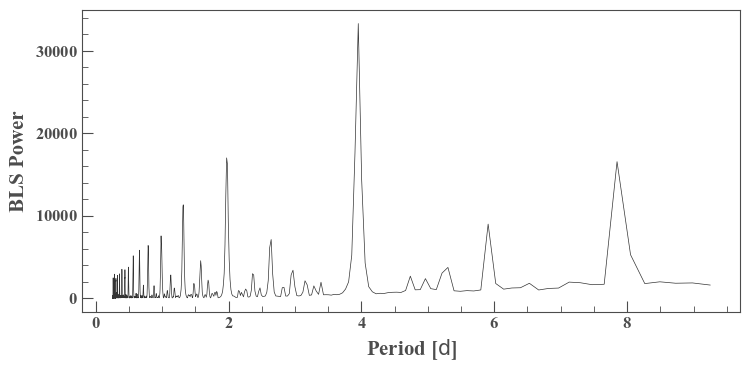

In [12]:
lcTransit = lc.copy()
test = BLS.from_lightcurve(lcTransit)
BLS.plot(test)
#I will need the period/phase right before and after transit, not just period at max power/transit.

In [13]:
per = test.period_at_max_power
print(per)
BLS.show_properties(test)

3.9529424305734286 d
lightkurve.Periodogram properties:
        Attribute            Description     Units
------------------------- ------------------ -----
             default_view             period      
                time_unit                day      
       depth_at_max_power              0.008      
    duration_at_max_power               0.25     d
   frequency_at_max_power              0.253 1 / d
                max_power         33317.9233      
      period_at_max_power             3.9529     d
transit_time_at_max_power             0.0877      
                    depth      array (1203,)      
                 duration      array (1203,)     d
                     flux     array (18094,)      
                frequency      array (1203,) 1 / d
                   period      array (1203,)     d
                    power      array (1203,)      
                      snr      array (1203,)      
                     time     array (18094,)      
             transit_time 

No period specified. Using period at max power
2019-12-16 11:00:16,612 WARNING: lightkurve.periodogram(get_transit_model): No period specified. Using period at max power
No duration specified. Using duration at max power
2019-12-16 11:00:16,613 WARNING: lightkurve.periodogram(get_transit_model): No duration specified. Using duration at max power
No transit time specified. Using transit time at max power
2019-12-16 11:00:16,615 WARNING: lightkurve.periodogram(get_transit_model): No transit time specified. Using transit time at max power


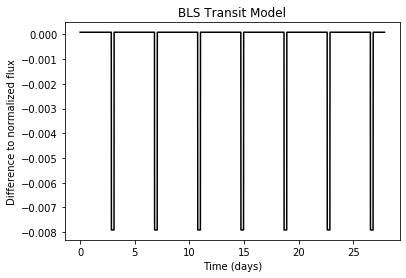

In [19]:
#I will need the period/phase right before and after transit, not just period at max transit.
N=12
lcTransit = lc.copy()
test = BLS.from_lightcurve(lcTransit)
model = BLS.get_transit_model(test)
time = max(model.time)-min(model.time)
period = 1/i
phase = (lc.time % period)
plt.plot(lc.time-lc.time[0], model.flux-1, c='k')
#plt.title("BLS Transit Model at {} days".format('%.3f'%(period)))
plt.title("BLS Transit Model")
plt.xlabel("Time (days)")
plt.ylabel("Difference to normalized flux")
#plt.savefig(os.path.join(downloadDir,"BLSyay.png"), bbox_inches='tight')
plt.show()

## Plotting a Phase Fold via BoxLeastSquares

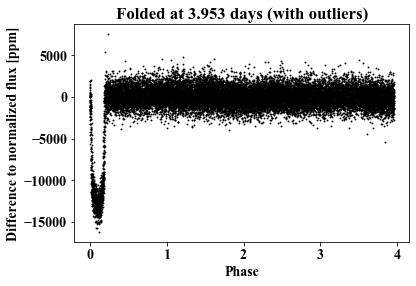

In [15]:
def phasefold(lc):
    time = max(lc.time)-min(lc.time)
    bls = BLS.from_lightcurve(lc)
    period = bls.period_at_max_power
    period = period.value
    phase = (lc.time % period)
    plt.scatter(phase, (lc.flux-1.)*1e6, marker=".", color="k", s=3)
    plt.title("Folded at {} days".format('%.3f'%(period))+' (with outliers)')
    plt.xlabel("Phase")
    plt.ylabel("Difference to normalized flux [ppm]")
    #plt.savefig(os.path.join(downloadDir,"PhaseFold_beforeout{}.pdf".format('%.3f'%(period))), bbox_inches='tight')
    plt.show()

phasefold(lcTransit)

## Plotting a Phase Fold via BoxLeastSquares (with Outlier Removal)

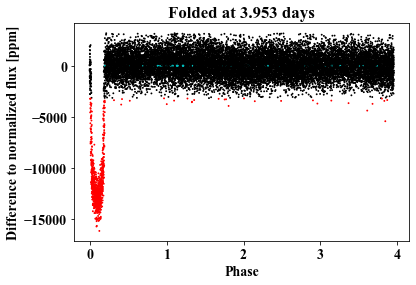

In [16]:
def phasefold2(lc):
    time = max(lc.time)-min(lc.time)
    bls = BLS.from_lightcurve(lc)
    period = bls.period_at_max_power
    period = period.value
    phase = (lc.time % period)
    
    flux_nomad = lc.flux-1
    mad = stats.median_absolute_deviation(lc.flux)
    std = np.std(flux_nomad)
        
    col = ['k']*len(phase)
    col = np.array(col)
    col[np.where(flux_nomad >= 4*mad)] = 'cyan'
    col[np.where(flux_nomad <= -4*mad)] = 'r'
    ind_norm = np.where(col == 'k')
    ind_outl_pos = np.where(col == 'cyan')
    ind_outl_neg = np.where(col == 'r')
    
    flux_mad = np.where(flux_nomad > 4*mad, 0, flux_nomad)

    plt.scatter(phase, (flux_mad)*1e6, marker=".", color=col, s=3)
    plt.title("Folded at {} days".format('%.3f'%(period)))
    plt.xlabel("Phase")
    plt.ylabel("Difference to normalized flux [ppm]")
    #plt.savefig(os.path.join(downloadDir,"PhaseFold_beforeout{}.pdf".format('%.3f'%(period))), bbox_inches='tight')
    plt.show()

phasefold2(lcTransit)

In [17]:
def window1(a, w=100, o=10, copy=False):
    sh = (a.size - w + 1, w)
    st = a.strides * 2
    print(a.strides)
    view = np.lib.stride_tricks.as_strided(a, strides = st, shape = sh)[0::o]
    if copy:
        return view.copy()
    else:
        return view
    #return (o-w, o+w)
    
#def window2(a, startpos):
    #a[N:N+11]
    
def count1(a, mad, std):
    firstapps = []
    #firstapp = (mad-lc)/std
    firstapp = (a - mad)/std
    for i in range (0, len(firstapp)):
        if firstapp[i] < std:
            firstapp[i] = 1
        else:
            firstapp[i] = 0
    firstapps.append(firstapp)
    outlier_count = np.count_nonzero(firstapps)
    return outlier_count

In [18]:
N = 10 
dt=5
time = max(lc.time)-min(lc.time)
dt = dt/24 #converting to day
period = 3.9611876601163045
phase = (lc.time % period)

##Binning below
#s = period / dt
#lcB = lc.bin(binsize=s, method='median') #Do not bin until neg outliers are removed
#phasebin = (lcB.time % period) #Do not bin until neg outliers are removed
##Binninng above
                    
## +Outlier removal below
flux_nomad = lc.flux-1
mad = stats.median_absolute_deviation(flux_nomad)
flux_mad = np.where(flux_nomad > 2*mad, 0, flux_nomad)
## +Outlier removal above
    
## -Outlier removal below
    
std = np.std(flux_nomad)
windows = window1(flux_nomad)
#print((mad-windows[5])/std)
count1(windows[5], mad, std)

#firstapps=[]
#for i in range(0, 11):
    #for j in range(0, len(windows[3])):
    #firstapp = (mad - windows[3][j])/std
    #firstapps.append(firstapp)
#return firstapps
    
## -Outlier removal above


(4,)


76

## Binning

2019-12-08 18:24:13,571 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:13,597 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:13,598 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.
2019-12-08 18:24:13,694 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:13,719 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:13,720 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.


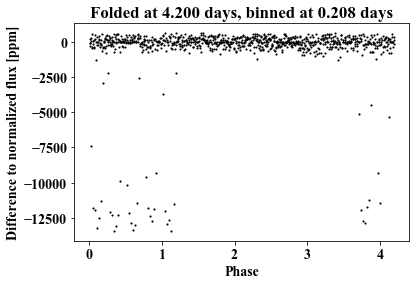

2019-12-08 18:24:13,982 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:14,011 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:14,012 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.
2019-12-08 18:24:14,105 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:14,126 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:14,129 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.


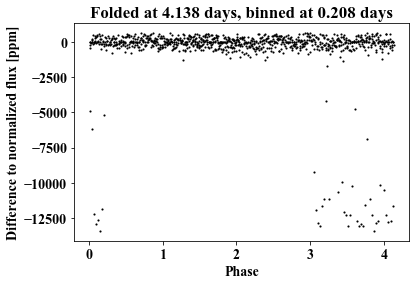

2019-12-08 18:24:14,403 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:14,428 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:14,429 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.
2019-12-08 18:24:14,523 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:14,545 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:14,546 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.


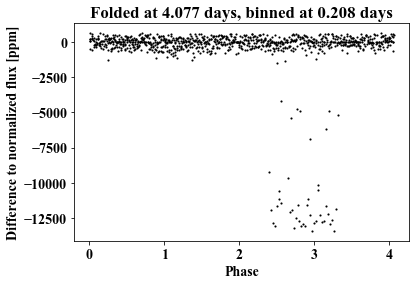

2019-12-08 18:24:14,812 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:14,838 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:14,840 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.
2019-12-08 18:24:14,933 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:14,954 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:14,955 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.


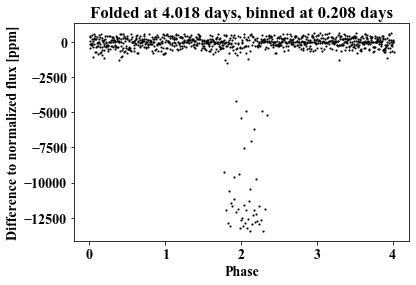

2019-12-08 18:24:15,219 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:15,241 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:15,242 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.
2019-12-08 18:24:15,323 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:15,342 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:15,342 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.


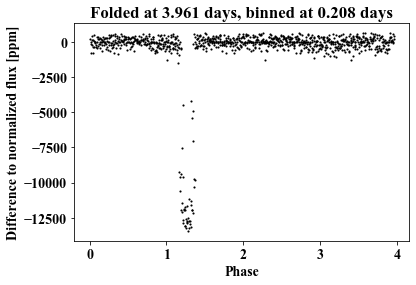

2019-12-08 18:24:15,593 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:15,615 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:15,616 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.
2019-12-08 18:24:15,697 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:15,715 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:15,716 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.


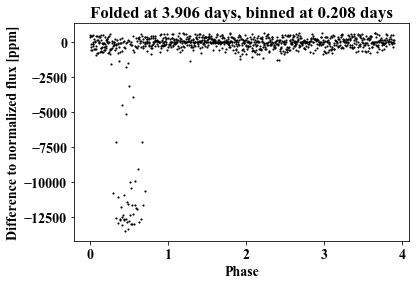

2019-12-08 18:24:15,962 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:15,983 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:15,984 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.
2019-12-08 18:24:16,065 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:16,083 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:16,084 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.


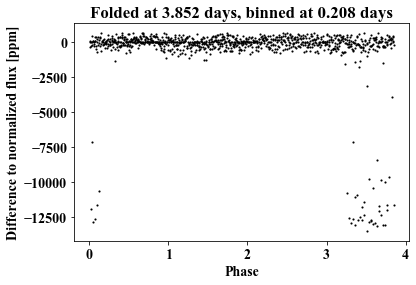

[4.2,
 4.1376374607581035,
 4.077099771591672,
 4.018307989481871,
 3.9611876601163045,
 3.9056685033252827,
 3.851684124605596]

In [19]:
def meandt(lc, N=10, dt=5):
    periods = []
    time = max(lc.time)-min(lc.time)
    dt = dt/24 #converting to day
    for i in np.arange(1/4.2, 1/3.8, (1/time * 1/N)): #p 3.8 to 4.2
        period = 1/i
        
        ##Binning below
        s = period / dt
        lcB = lc.bin(binsize=s, method='median')
        phasebin = (lcB.time % period)
        ##Binninng above
                    
        ##Outlier removal below
        flux_nomad = lcB.flux-1
        mad = stats.median_absolute_deviation(flux_nomad)
        flux_mad = np.where(flux_nomad > 2*mad, 0, flux_nomad)
        ##Outlier removal above
    
        plt.scatter(phasebin, (flux_mad)*1e6, marker=".", color="k", s=5)
        plt.title("Folded at {} days".format('%.3f'%(period))+', binned at {} days'.format('%.3f'%(dt)))
        plt.xlabel("Phase")
        plt.ylabel("Difference to normalized flux [ppm]")
        plt.savefig(os.path.join(downloadDir,"PhaseFoldBin_{}.pdf".format('%.3f'%(period))), bbox_inches='tight')
        plt.show()
        periods.append(period)
    return periods

meandt(lc)


## Window Sliding

In [20]:
def window(a, w=50, o=5, copy=False):
    sh = (a.size - w + 1, w)
    st = a.strides * 2
    view = np.lib.stride_tricks.as_strided(a, strides = st, shape = sh)[0::o]
    if copy:
        return view.copy()
    else:
        return view
    #return (o-w, o+w)
    
#def window2(a, startpos):
    #a[N:N+11]
    
def count2(a, mad):
    firstapps = []
    #firstapp = (mad-lc)/std
    #firstapp = (a - mad)/std
    #firstapp = a
    firstapp = np.zeros(len(a))
    for i in range (0, len(a)):
        if a[i] <= -4*mad:
            firstapp[i] = 1
        else:
            firstapp[i] = 0
    firstapps.append(firstapp)
    outlier_count = np.count_nonzero(firstapp)
    return outlier_count

def count3(a, mad):
    firstapps = []
    firstapp = a
    firstapp[np.where(a >= 4*mad)] = 0
    firstapp[np.where(a <= -4*mad)] = 1
    outlier_count = np.count_nonzero(firstapp)
    return outlier_count


## Counting Outliers In Terms of Phase (Works!)

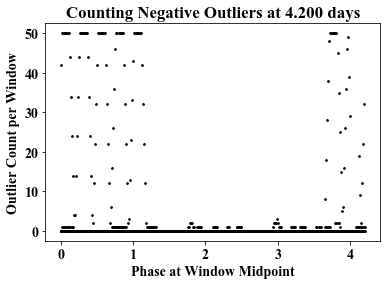

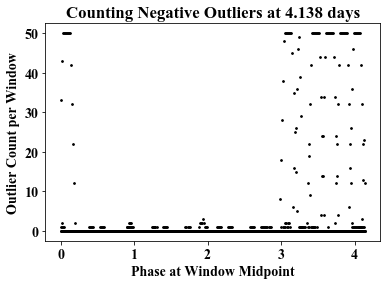

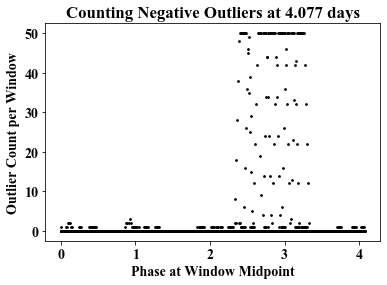

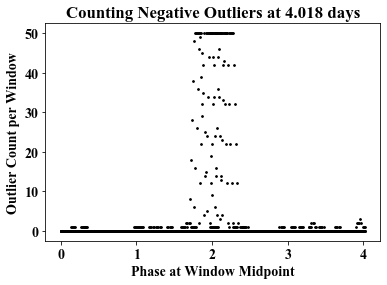

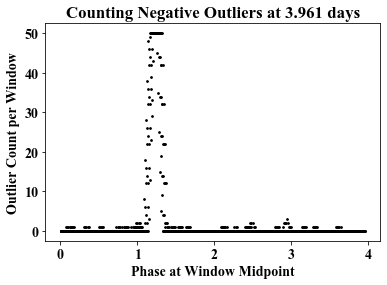

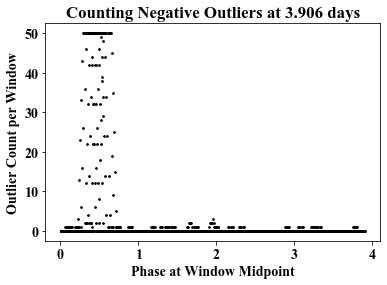

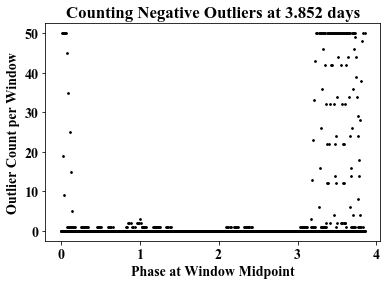

[4.2,
 4.1376374607581035,
 4.077099771591672,
 4.018307989481871,
 3.9611876601163045,
 3.9056685033252827,
 3.851684124605596]

In [21]:
def gridfreqcount(lc,N=10):
    periods=[]
    phases=[]
    time = max(lc.time)-min(lc.time)
    for i in np.arange(1/4.2, 1/3.8, (1/time * 1/N)): #p 3.8 to 4.2
        period = 1/i
        phase = (lc.time % period)
        
        ## Pos outlier removal below
        flux_nomad = lc.flux-1
        MAD = stats.median_absolute_deviation(flux_nomad)
        flux_mad = np.where(flux_nomad > 4*mad, 0, flux_nomad)
        ## Pos outlier removal above
        
        ##Counting neg outlier below
        col = [0]*len(phase)
        col = np.array(col)
        col[np.where(flux_nomad <= -4*MAD)] = 1 #'r'
        #print(len(col))
        windows = window(col, w=50, o=10)
        window_phase = window(phase, w=50, o=10)
        #print(windows[50])
        counts = []
        for j in range(0, len(windows)):
            outlier_count = np.count_nonzero(windows[j])
            counts.append(outlier_count)
        ##Counting neg outlier above
        
        #print(counts)
        plt.scatter(window_phase[:,0], counts, marker="o", color="k", s=3)
        #plt.scatter(phase, (flux_mad)*1e6, marker=".", color="k", s=3)
        plt.title("Counting Negative Outliers at {} days".format('%.3f'%(period)))
        plt.xlabel("Phase at Window Midpoint")
        plt.ylabel("Outlier Count per Window")
        #plt.savefig(os.path.join(downloadDir,"NegCount_{}.pdf".format('%.3f'%(period))), bbox_inches='tight')
        plt.show()
        periods.append(period)
        phases.append(phase)
    return periods

gridfreqcount(lcTransit)

## Applying CDF to the Outlier Count

True
[2.30133467 2.31522359 2.32911251 ... 0.68004968 0.69393808 0.70782648] [0. 0. 0. ... 1. 1. 1.]
[1.15200203e-03 1.25042948e-03 1.33146353e-03 ... 4.18883601e+00
 4.19812836e+00 4.19964819e+00]
2.0954114050509713


2019-12-08 18:24:17,270 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:17,291 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:17,292 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.
2019-12-08 18:24:17,397 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:17,415 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:17,416 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.


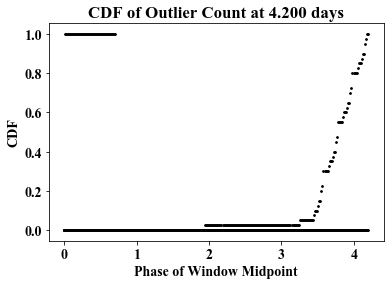

True
[1.25734722 1.27123615 1.28512507 ... 0.07260001 0.08648841 0.10037681] [0. 0. 0. ... 1. 1. 1.]
[3.15800080e-03 5.06944824e-03 8.28107277e-03 ... 4.13600021e+00
 4.13637045e+00 4.13689800e+00]
2.0858279042147405


2019-12-08 18:24:17,633 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:17,653 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:17,654 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.
2019-12-08 18:24:17,762 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:17,778 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:17,779 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.


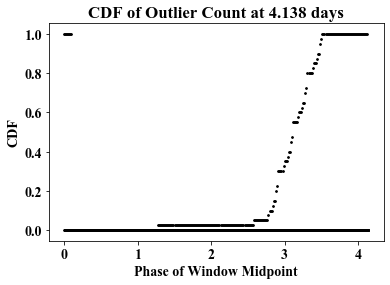

True
[0.2439089  0.25779782 0.27168674 ... 3.56002528 3.57391368 3.58780208] [0. 0. 0. ... 1. 1. 1.]
[2.63421041e-03 4.22573266e-03 7.08685941e-03 ... 4.07235518e+00
 4.07335074e+00 4.07360190e+00]
1.995253743595818


2019-12-08 18:24:18,047 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:18,067 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:18,069 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.
2019-12-08 18:24:18,174 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:18,189 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:18,190 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.


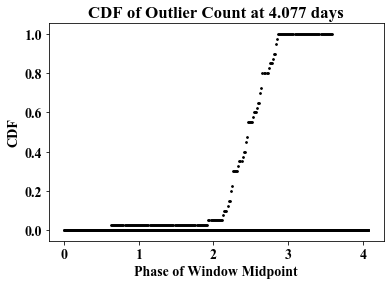

True
[3.27800613 3.29189505 3.30578397 ... 2.92856521 2.94245361 2.95634201] [0. 0. 0. ... 1. 1. 1.]
[1.60749721e-03 6.80800727e-03 7.78701274e-03 ... 4.01469007e+00
 4.01550720e+00 4.01641270e+00]
2.0274404857918746


2019-12-08 18:24:18,400 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:18,418 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:18,420 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.
2019-12-08 18:24:18,521 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:18,537 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:18,537 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.


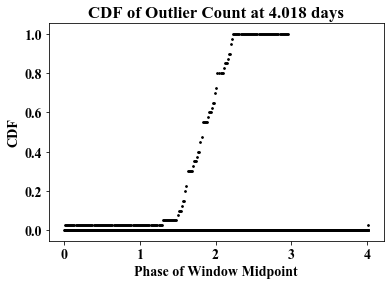

True
[2.26465619 2.27854511 2.29243403 ... 2.31505758 2.32894598 2.34283438] [0. 0. 0. ... 1. 1. 1.]
[0.00477868 0.00485879 0.00745633 ... 3.95568278 3.95826554 3.95864058]
2.023618579220759


2019-12-08 18:24:18,732 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:18,750 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:18,751 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.
2019-12-08 18:24:18,853 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:18,869 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:18,870 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.


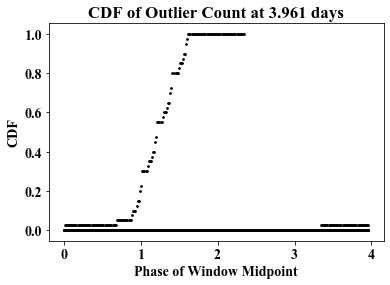

True
[1.27971204 1.29360096 1.30748988 ... 1.71874753 1.73263593 1.74652433] [0. 0. 0. ... 1. 1. 1.]
[0.00433866 0.00448173 0.00769296 ... 3.89947302 3.90471298 3.90547782]
1.913936056605374


2019-12-08 18:24:19,068 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:19,087 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:19,088 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.
2019-12-08 18:24:19,188 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:19,204 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:19,205 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.


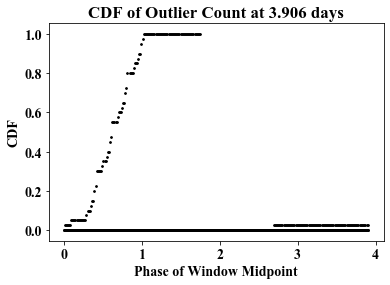

True
[0.3219958  0.33588472 0.34977365 ... 1.13892194 1.15281034 1.16669874] [0. 0. 0. ... 1. 1. 1.]
[2.33466466e-04 2.25611482e-03 8.89797314e-03 ... 3.84897758e+00
 3.85018008e+00 3.85118174e+00]
1.8840633671250613


2019-12-08 18:24:19,403 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:19,423 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:19,424 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.
2019-12-08 18:24:19,523 DEBUG: matplotlib.backends.backend_pdf(fontName): Assigning font /b'F1' = 'C:\\WINDOWS\\Fonts\\timesbd.ttf'
2019-12-08 18:24:19,538 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Embedding font C:\WINDOWS\Fonts\timesbd.ttf.
2019-12-08 18:24:19,539 DEBUG: matplotlib.backends.backend_pdf(writeFonts): Writing TrueType font.


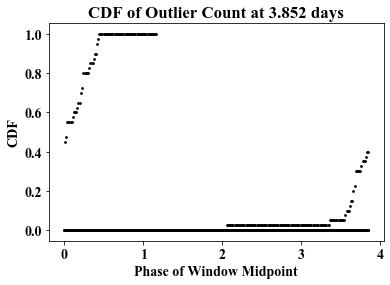

In [22]:
def countcdf(lc,N=10):
    periods=[]
    phases=[]
    time = max(lc.time)-min(lc.time)
    for i in np.arange(1/4.2, 1/3.8, (1/time * 1/N)): #p 3.8 to 4.2
        period = 1/i
        phase = (lc.time % period)
        #print(phase)
        
        ## Pos outlier removal below
        flux_nomad = lc.flux-1
        MAD = stats.median_absolute_deviation(flux_nomad)
        flux_mad = np.where(flux_nomad > 4*mad, 0, flux_nomad)
        ## Pos outlier removal above
        
        ##Counting neg outlier below
        col = [0]*len(phase)
        col = np.array(col)
        col[np.where(flux_nomad <= -4*MAD)] = 1 #'r'
        windows = window(col, w=40, o=10)
        window_phase = window(phase, w=40, o=10)
        x = window_phase[:,0]
        xn = np.linspace(min(x), max(x), len(x))
        counts = []
        for j in range(0, len(windows)):
            outlier_count = np.count_nonzero(windows[j])
            counts.append(outlier_count)
        ##Counting neg outlier above
        
        ##CDF below
        
        c_cdf = np.sort(counts)
        y = c_cdf/c_cdf[-1]
        print(len(y)==len(x))
        #print(y)
        #print(x)
        #print(c_cdf)
        #p_cdf = np.sort(window_phase[:,0])
        #y_cdf = np.arange(1, len(x_cdf)+1) / len(x_cdf)
        
        ##CDF above
        print(x,y)
        print(np.sort(x))
        print(np.mean(x))
        
        plt.scatter(x, y, marker="o", color="k", s=3)
        plt.title("CDF of Outlier Count at {} days".format('%.3f'%(period)))
        plt.xlabel("Phase of Window Midpoint")
        plt.ylabel("CDF")
        plt.savefig(os.path.join(downloadDir,"CountCDF_{}.pdf".format('%.3f'%(period))), bbox_inches='tight')
        plt.show()
        periods.append(period)
        phases.append(phase)
    #return periods

countcdf(lcTransit)

## Polynomial Fit of CDF

           10          9         8         7         6         5
-0.007938 x  + 0.1632 x - 1.421 x + 6.844 x - 19.92 x + 35.97 x
          4         3         2
 - 39.81 x + 25.68 x - 8.678 x + 1.234 x - 0.04091


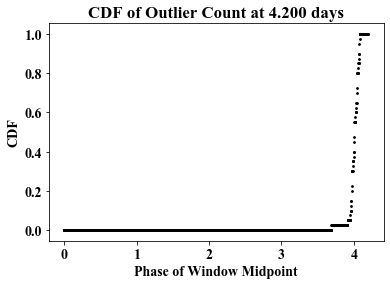

          10          9         8        7         6        5         4
-0.00975 x  + 0.1981 x - 1.707 x + 8.14 x - 23.48 x + 42.1 x - 46.37 x
          3         2
 + 29.89 x - 10.17 x + 1.474 x - 0.05272


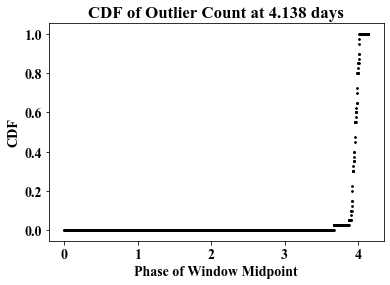

          10          9         8         7         6         5
-0.01208 x  + 0.2401 x - 2.024 x + 9.436 x - 26.62 x + 46.65 x
          4         3         2
 - 50.23 x + 31.65 x - 10.53 x + 1.5 x - 0.05223


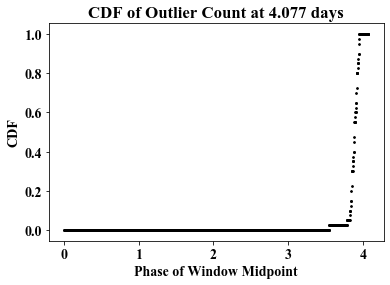

           10          9         8         7         6         5
-0.009891 x  + 0.1977 x - 1.674 x + 7.823 x - 22.08 x + 38.67 x
         4         3         2
 - 41.5 x + 25.98 x - 8.551 x + 1.197 x - 0.04137


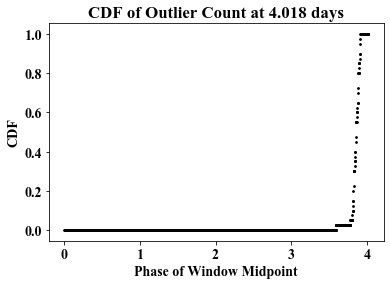

          10          9         8         7         6         5
-0.01699 x  + 0.3285 x - 2.695 x + 12.23 x - 33.61 x + 57.38 x
          4         3         2
 - 60.19 x + 36.92 x - 11.94 x + 1.644 x - 0.05515


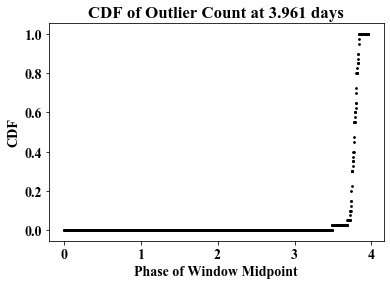

         10          9         8         7         6         5
-0.0225 x  + 0.4256 x - 3.416 x + 15.18 x - 40.84 x + 68.31 x
          4         3         2
 - 70.26 x + 42.33 x - 13.51 x + 1.859 x - 0.06628


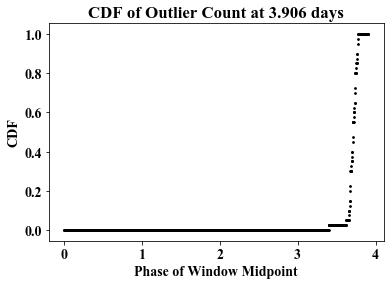

          10          9         8        7         6         5
-0.02039 x  + 0.3847 x - 3.076 x + 13.6 x - 36.37 x + 60.43 x
          4         3         2
 - 61.67 x + 36.84 x - 11.63 x + 1.574 x - 0.05244


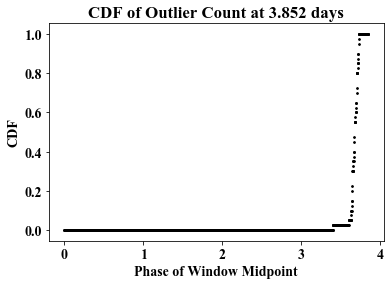

[4.2,
 4.1376374607581035,
 4.077099771591672,
 4.018307989481871,
 3.9611876601163045,
 3.9056685033252827,
 3.851684124605596]

In [23]:
def countpolyfit(lc,N=10):
    periods=[]
    phases=[]
    time = max(lc.time)-min(lc.time)
    for i in np.arange(1/4.2, 1/3.8, (1/time * 1/N)): #p 3.8 to 4.2
        period = 1/i
        phase = (lc.time % period)
        
        ## Pos outlier removal below
        flux_nomad = lc.flux-1
        MAD = stats.median_absolute_deviation(flux_nomad)
        flux_mad = np.where(flux_nomad > 4*mad, 0, flux_nomad)
        ## Pos outlier removal above
        
        ##Counting neg outlier below
        col = [0]*len(phase)
        col = np.array(col)
        col[np.where(flux_nomad <= -4*MAD)] = 1 #'r'
        #print(len(col))
        windows = window(col, w=40, o=10)
        window_phase = window(phase, w=40, o=10)
        x = window_phase[:,0]
        xs = np.sort(x)
        counts = []
        for j in range(0, len(windows)):
            outlier_count = np.count_nonzero(windows[j])
            counts.append(outlier_count)
        ##Counting neg outlier above
        
        ##CDF below
        c_cdf = np.sort(counts)
        y = c_cdf/c_cdf[-1]
        ##CDF above
        
        ##Polyfit below
        xp = np.linspace(min(xs), max(xs), len(xs))
        coefficients = np.polyfit(xs, y, deg=10) #test with deg=1 to see if the mean of the cdf appears
        polynomial = np.poly1d(coefficients)
        print(polynomial)
        yp = polynomial(xp)
        ##Polyfit above
        
        plt.scatter(xs, y, marker="o", color="k", s=3)
        #plt.plot(xp, yp, 'b-')
        plt.title("CDF of Outlier Count at {} days".format('%.3f'%(period)))
        plt.xlabel("Phase of Window Midpoint")
        plt.ylabel("CDF")
        #plt.savefig(os.path.join(downloadDir,"CountCDF_{}.pdf".format('%.3f'%(period))), bbox_inches='tight')
        plt.show()
        periods.append(period)
        phases.append(phase)
    return periods

countpolyfit(lcTransit)

## Derivative of Polynomial Fit